In [1]:
#pip install tropycal

In [2]:
#pip install  climetlab

In [3]:
#pip install --upgrade fair-research-login 

In [4]:
#pip install geocat.viz

In [8]:
import os
import collections
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma
import metpy.calc as mpcalc
import xskillscore as xs
import xcdat as xc

from datetime import datetime
from skimage.feature import peak_local_max
import cartopy.crs as ccrs
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt, sosfilt,lfilter
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib.patches import Polygon
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

from tropycal import tracks, utils
import climetlab as cml

import cmaps as gvcmaps
import geocat.viz.util as gvutil
import geocat.viz as gv


In [9]:
def plot_boundaries(ax):
    """This function plots geographic and political boundaries on the provided axes."""
    # Plot coastlines and political boundaries
    #ax.add_feature(cfeature.STATES.with_scale('50m'), linewidths=0.5, linestyle='solid', edgecolor='k')
    #ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidths=1.0, linestyle='solid', edgecolor='k')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidths=0.5, linestyle='solid', edgecolor='k')
            
    # Fill in continents in light gray
    #ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face')
    
    #load background figure
    #ax.stock_img()

    # Return axes instance
    return ax

In [10]:
def generate_coslat_weight(ds):
    # make weights as cosine of the latitude and broadcast
    weights = np.cos(np.deg2rad(ds.lat))
    _, weights = xr.broadcast(ds,weights)
    return weights

In [11]:
def plot_gridlines(ax,projection):
    #Add gridlines and labels
    gl = ax.gridlines(crs=projection, draw_labels=True,
          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top  = False
    gl.ylabels_left = False
    gl.xlines       = True
    gl.ylines       = True
    gl.xformatter   = cticker.LongitudeFormatter()
    gl.yformatter   = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': fontz*0.6, 'color': 'black'}
    gl.ylabel_style = {'size': fontz*0.6, 'color': 'black'}
    ax.xaxis.set_tick_params(labeltop=False)
    ax.yaxis.set_tick_params(labelright=False) 

In [12]:
def south_north_cross(case,group,year,period,frequency,exps,htag,path_in):
    var_list = ['Nudge_U','Nudge_V','Nudge_T','Nudge_Q']
    var_unts = ['m s$^{-1}$ 3hr$^{-1}$','m s$^{-1}$ 3hr$^{-1}$','K 3hr$^{-1}$','g kg$^{-1}$ 3hr$^{-1}$']
    var_mins = [-0.2,-0.2,-0.2,-0.04] 
    var_maxs = [ 0.2, 0.2, 0.2, 0.04] 
    var_fact = [1.0,1.0,1.0,1e3] 
    nudge_tau = 3.0 * 3600.0 #3-hour
    itime = 0

    xminor_loc=10
    xmajor_loc=30
    yminor_loc=100
    ymajor_loc=200
    
    #cmap = plt.cm.get_cmap('RdBu_r')
    # Import the default color map
    newcmp = gvcmaps.BlueYellowRed
    index = [5, 20,  35, 50, 65, 85, 95, 110, 120, 125, 130, 135, 150,  165, 180, 200, 210, 220, 235, 250 ]
    color_list = [newcmp[i].colors for i in index]
    #-- Change to white
    #color_list[9]=[ 1., 1., 1.]
    #color_list[10]=[ 1., 1., 1.]
    # Define dictionary for kwargs
   # nlev = len(color_list) + 1
    #clevs = np.linspace(var_mins[i], var_maxs[i],nlev)
   # kwargs = dict(
   #     vmin = var_mins[i],
   #     vmax = var_maxs[i],
   #     levels = clevs,
   #     colors=color_list,
   #     #add_colorbar=False,
   #     extend='both',
   #     #transform=ccrs.PlateCarree(),  # ds projection
   #     zorder=1 
   # )
    
    print("working on ",exp_name,exp_year,exp_mtag,period)

    df={}
    model_list=[]
    for i,exp in enumerate(exps.keys()):
        model = exps[exp]
        if model not in model_list:
            model_list.append(exps[exp])
        path = os.path.join(path_in.replace("%(CASENAME)",exp),
                        "{}.{}.{}.nc".format(exp,htag,period))
        #print( xr.open_dataset(path))
        df[model] = xr.open_dataset(path)
    fcl = len(exps.keys())/4.0     
    fgw = 22 * fcl
    fgh = 18
    frac = fgh/fgw 
    fontz = 14 * fcl
    nrows=len(var_list)
    ncols=len(model_list)
    data_projection = ccrs.PlateCarree() #ccrs.Robinson() #ccrs.PlateCarree()    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=(fgw,fgh), 
                             #subplot_kw={'projection': data_projection}
                            )
    cmap = plt.get_cmap('RdBu_r')
    
    # Create the plot
    pltName = "sourth_north_cross" #workdir + '/' + 'plot_hus_0.png'
    
    # draw filled contours.    
    for i,var in enumerate(var_list):
        vunt = var_unts[i]
        vfac = var_fact[i] * nudge_tau
        clevs = np.linspace(var_mins[i],var_maxs[i],11)
        for j,model in enumerate(model_list):
            lat = df[model]['lat'] 
            lev = df[model]['lev']
            ds = df[model].mean(dim=['lon'], skipna=True)
            vtend = ds[var][0,:,:] * vfac 
            if model == "NDGUVTQ": 
                vso = vtend.copy() 
                vso[:,:] = vso[:,:] ** 2 
                rmso = np.mean(vso) 
                print("obs:",rmso)
                vref = vtend.copy()
                rmse = 0.0
                pcor = 1.0
                metrics_str = "RMSE_norm/PCOR: {:0.1f}/{:0.2f}".format(rmse,pcor)
            else: 
                if not np.all(vtend == 0):
                    weights = generate_coslat_weight(vtend)
                    rmse = xs.rmse(vref,vtend, dim=["lev", "lat"], weights=weights.astype("float64"),skipna=True)
                    pcor = xs.pearson_r(vref,vtend, dim=["lev", "lat"], weights=weights.astype("float64"),skipna=True)
                    rmse = rmse / rmso
                    metrics_str = "RMSE_norm/PCOR: {:0.1f}/{:0.2f}".format(rmse.values,pcor.values)
                else:
                    metrics_str = "RMSE_norm/PCOR: NA/NA"

            #reverse order from bottom to top
            #lev = lev[::-1]
            #vtend = vtend[:,::-1] * vfac
            #print(vtend)
            print(var,model)
            
            #print(vtend.min(),vtend.max())
            k = i * len(model_list) + j
            
            # Import the default color map
            newcmp = gvcmaps.BlueYellowRed
            index = [5, 20,  35, 50, 65, 85, 95, 110, 120, 125, 130, 135, 150,  165, 180, 200, 210, 220, 235, 250 ]
            color_list = [newcmp[i].colors for i in index]
            #-- Change to white
            #color_list[9]=[ 1., 1., 1.]
            #color_list[10]=[ 1., 1., 1.]
            # Define dictionary for kwargs
            nlev = len(color_list) + 1
            clevs = np.linspace(var_mins[i], var_maxs[i],nlev)
            kwargs = dict(
                #vmin = var_mins[i],
                #vmax = var_maxs[i],
                levels = clevs,
                colors=color_list,
                #add_colorbar=False,
                extend='both',
                #transform=ccrs.PlateCarree(),  # ds projection
                zorder=1 
            )
            
            norm = matplotlib.colors.BoundaryNorm(np.linspace(var_mins[i], var_maxs[i],nlev), nlev-1 )
            
            # Make a filled contour plot
            # Contouf-plot U data (for filled contours)
            fillplot = axes.flat[k].contourf(lat,lev,vtend, norm=norm, **kwargs)
            #fillplot = vtend.plot.contourf(ax=axes.flat[k],**kwargs
            
            #-- set titles
            #fig.suptitle(title, fontsize=24, **fontname, y=1.01)
            #ax.set_title(subtitle, pad=13, fontsize=14, **fontname)
            # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
            #axes.flat[k].set_title('{}: {}'.format(model,str(var)),fontsize=fontz*0.6, color='black')
            gvutil.set_titles_and_labels(axes.flat[k],
                                         lefttitle=model,
                                         lefttitlefontsize=fontz*frac*1.2,
                                         righttitle=metrics_str,
                                         righttitlefontsize=fontz*frac*1.2,
                                         labelfontsize = fontz*frac*1.2,
                                         xlabel="",
                                         ylabel="")
            
            #-- add grid lines
            axes.flat[k].grid(color='silver',zorder=2,linestyle = '--',linewidth = 0.2)
            axes.flat[k].grid(False, which='minor')
            
            #-- ticks settings for both axis
            axes.flat[k].minorticks_on()
            #-- x-ticks
            xticks = np.arange(-60,90,30)
            xlabels = ['60S','30S','0','30N', '60N']
            axes.flat[k].set_xticks(xticks)
            axes.flat[k].set_xticklabels(xlabels)
            axes.flat[k].xaxis.set_minor_locator(MultipleLocator(xminor_loc))
            axes.flat[k].xaxis.set_major_locator(MultipleLocator(xmajor_loc))
            
            # Set the y-axis to logarithmic scale
            #axes.flat[k].set_yscale('log')
            # Invert the y-axis
            axes.flat[k].invert_yaxis()
            axes.flat[k].set_ylabel('Dummy Pres. (1000A+B)',fontsize=fontz*frac*1.1)
            
            #-- y-ticks
            yticks = np.arange(min(lev),max(lev), 100.)
            ylabels = [str(s) for s in yticks]
            axes.flat[k].set_yticks(yticks)
            axes.flat[k].yaxis.set_minor_locator(MultipleLocator(yminor_loc))
            axes.flat[k].yaxis.set_major_locator(MultipleLocator(ymajor_loc))
            
            axes.flat[k].yaxis.set_tick_params(labelsize=fontz*frac*1.2, labelcolor='black',
                                               direction='out', length=3, which='both',
                                               right=False,labelright=False)
            axes.flat[k].yaxis.set_tick_params(length=2, which='minor')
            
            axes.flat[k].xaxis.set_tick_params(labelsize=fontz*frac*1.2, labelcolor='black',
                                               direction='out', length=3, which='both',
                                               top=False,labeltop=False)
            axes.flat[k].xaxis.set_tick_params(length=2, which='minor')

            # Create colorbar
            cb = plt.colorbar(fillplot,ax=axes.flat[k],
                              #ticks=np.linspace(var_mins[i], var_maxs[i], nlev),
                              drawedges=True,
                              extendfrac='auto',
                              extendrect=True,
                              norm = norm,
                              orientation='horizontal',
                              format="{x:.2f}",
                              pad=0.15,
                              aspect=20 *frac * fcl,
                              shrink=1.1 *frac * fcl)
            cb.set_ticks(ticks=clevs,labels=clevs,fontsize=fontz*frac*1.1)
            cb.set_label(label='{}({})'.format(var,vunt),fontsize=fontz*frac*1.2)
            tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator
            cb.update_ticks()
            #plt.show() 

            #cb.ax.set_ticklabels(['{:.2f}'.format(x) for x in cb.get_ticks()])
            #labels = []
            #for i,tick in enumerate(clevs):
            #    if i % 5 == 0:
            #        labels.append('{:.2f}'.format(clevs[i]))
            #    else:
            #        labels.append('')
            #cb.set_ticks(ticks=clevs,labels=labels,fontsize=fontz*frac*0.90)
            #cb.set_label(label=var,fontsize=fontz*frac*0.90)
            #plt.show()
        plt.tight_layout()
    plt.show()
    fig.savefig('fig_pres_lat_{}_{}_{}_{}.png'.format(case,group,frequency,period))

working on  Sandy 2012 UNETOLDUV 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U NDGUV
Nudge_U UNETOLD_UV
Nudge_U UNETOLD_Renorm_UV
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V NDGUV
Nudge_V UNETOLD_UV
Nudge_V UNETOLD_Renorm_UV
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T NDGUV
Nudge_T UNETOLD_UV
Nudge_T UNETOLD_Renorm_UV
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q NDGUV
Nudge_Q UNETOLD_UV
Nudge_Q UNETOLD_Renorm_UV


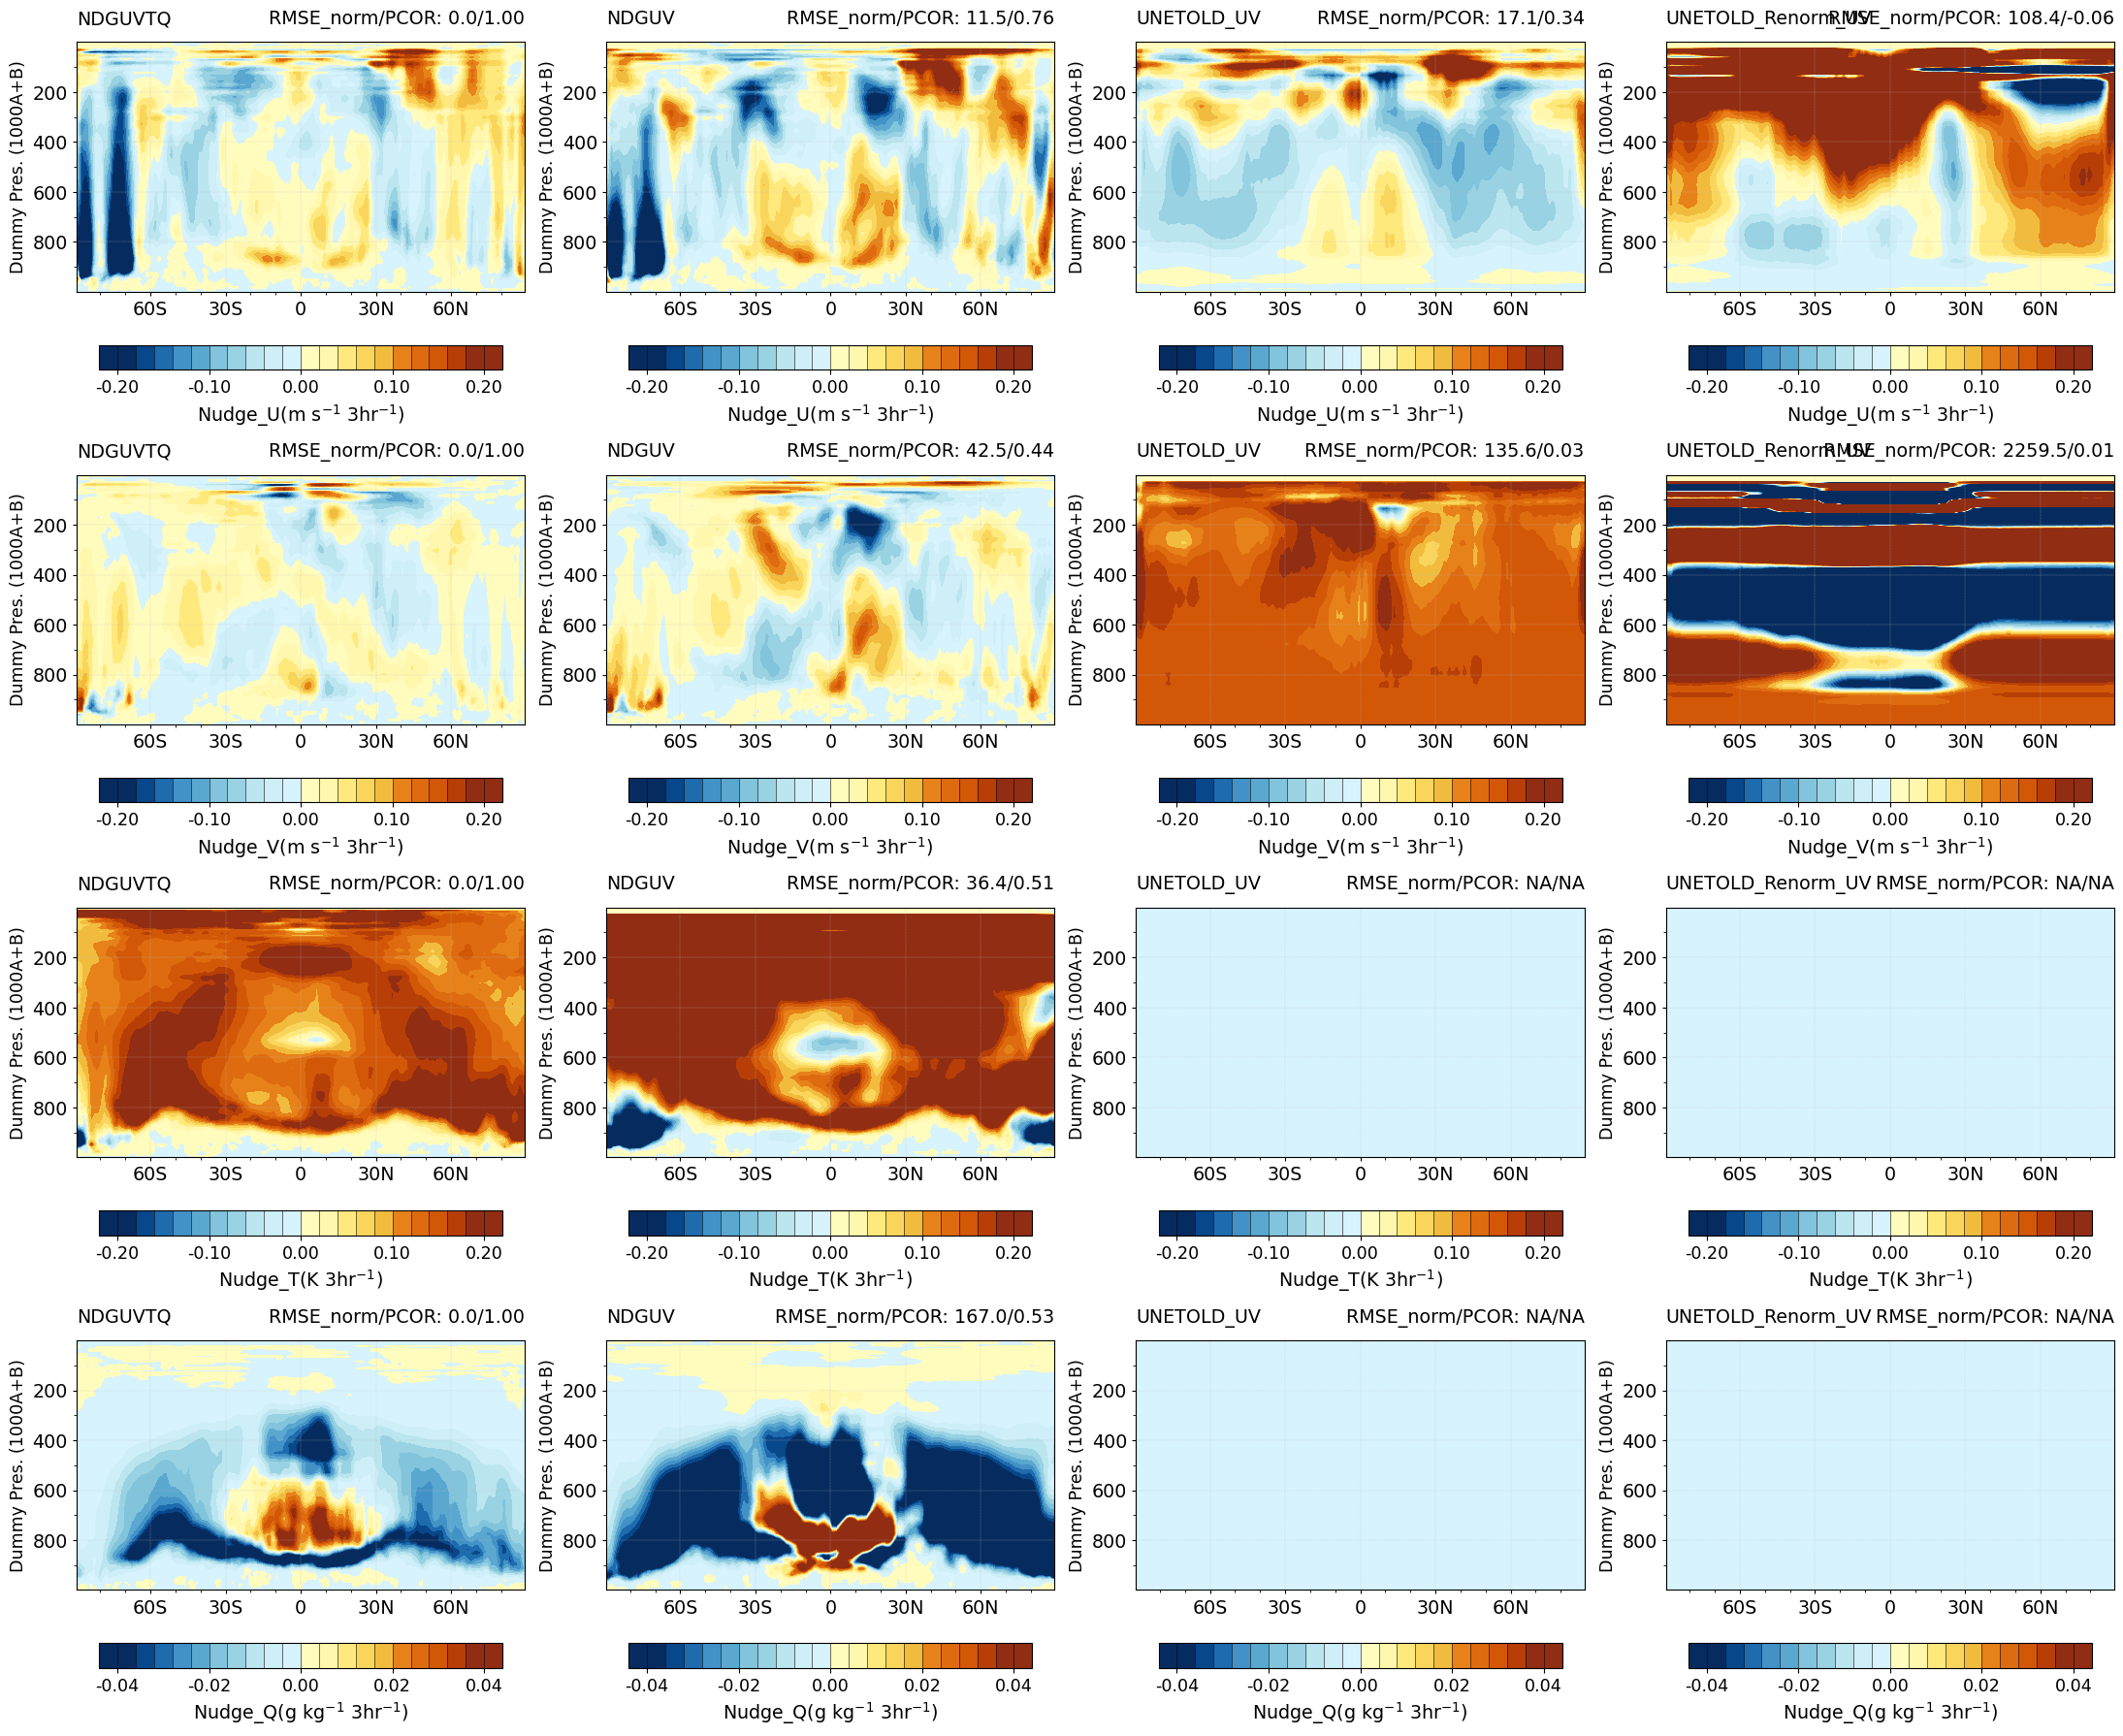

In [13]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mtag  = "UNETOLDUV" # u,v,t,q, no spacial treatment 
    exp_mstr  = "UNET_OLDUV" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                  'NDGUVTQ',
                 'SANDY2012_NDGUV_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                    'NDGUV',
                 'MLGLBUNETUV_Stage2_SANDY2012_EN01_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':  '{}_{}'.format('UNETOLD','UV'),
                 'MLGLBUNETUV_Rnorm_SANDY2012_EN01_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':   '{}_{}'.format('UNETOLD_Renorm','UV')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_UNFv0 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_UNFv0_UV
Nudge_U UNET_UNFv0_UVT
Nudge_U UNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_UNFv0_UV
Nudge_V UNET_UNFv0_UVT
Nudge_V UNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_UNFv0_UV
Nudge_T UNET_UNFv0_UVT
Nudge_T UNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_UNFv0_UV
Nudge_Q UNET_UNFv0_UVT
Nudge_Q UNET_UNFv0_UVTQ


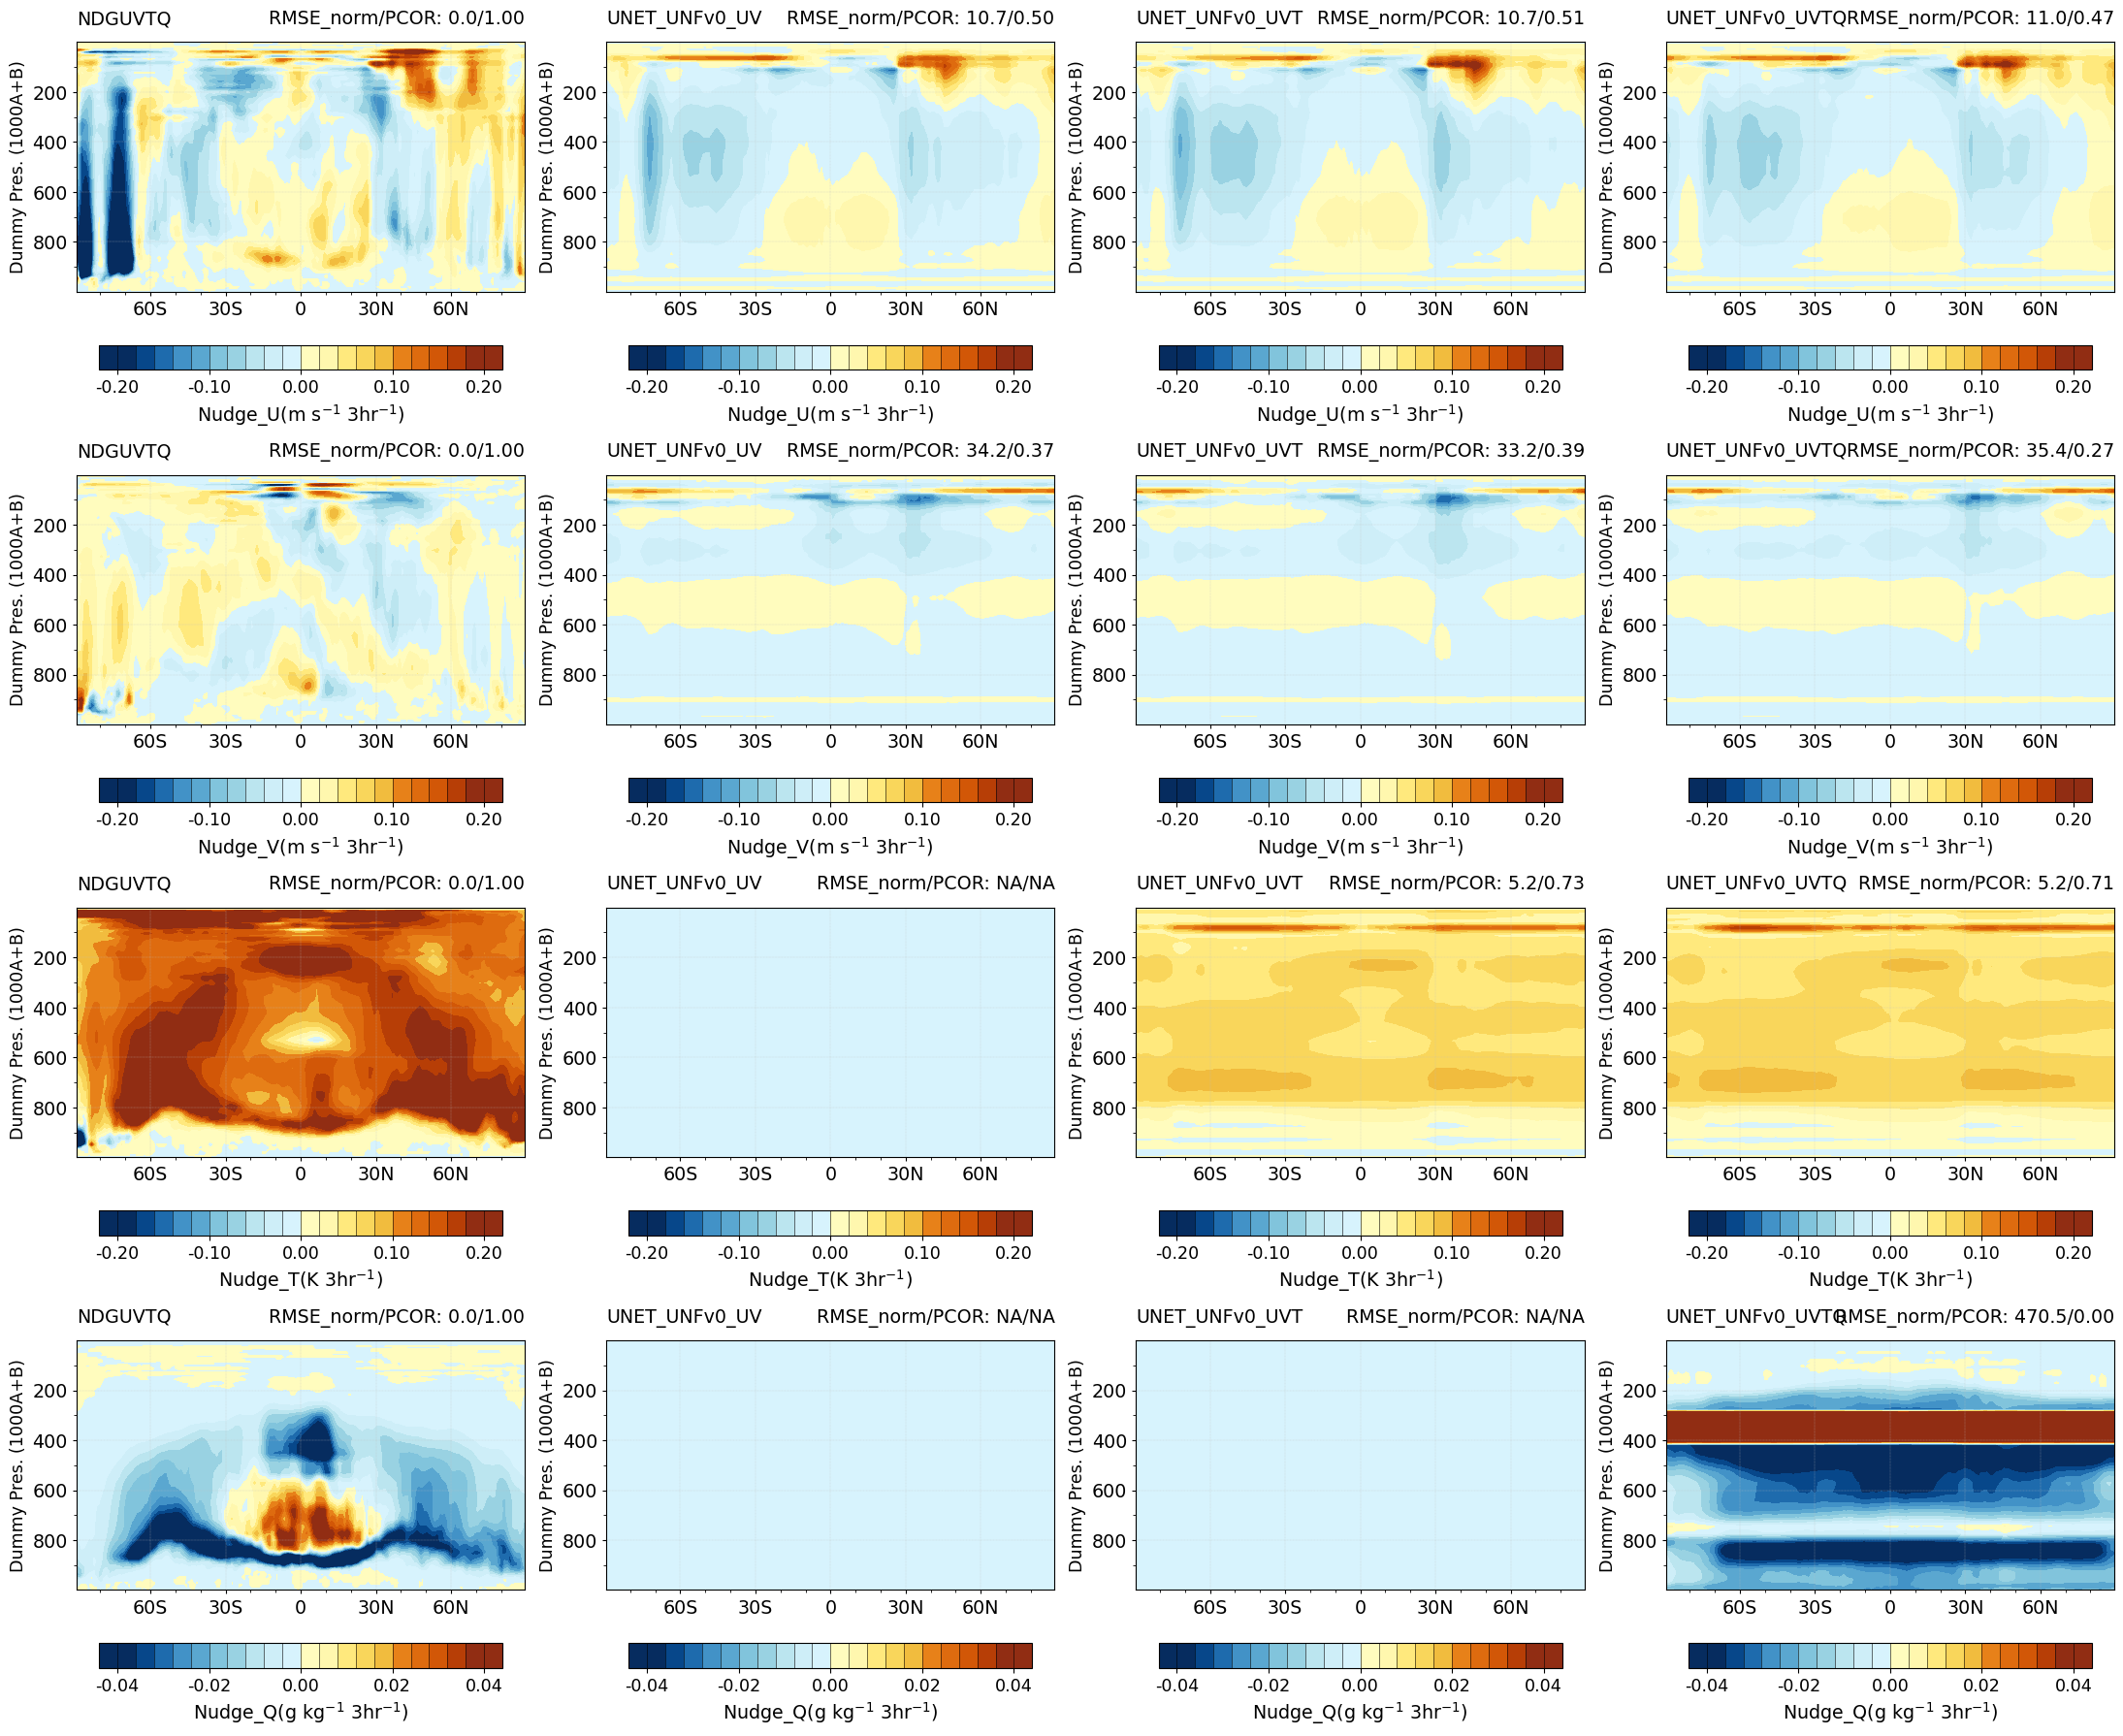

In [14]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_UNFv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_UNFv0" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_UNFv1 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_UNFv1_UV
Nudge_U UNET_UNFv1_UVT
Nudge_U UNET_UNFv1_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_UNFv1_UV
Nudge_V UNET_UNFv1_UVT
Nudge_V UNET_UNFv1_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_UNFv1_UV
Nudge_T UNET_UNFv1_UVT
Nudge_T UNET_UNFv1_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_UNFv1_UV
Nudge_Q UNET_UNFv1_UVT
Nudge_Q UNET_UNFv1_UVTQ


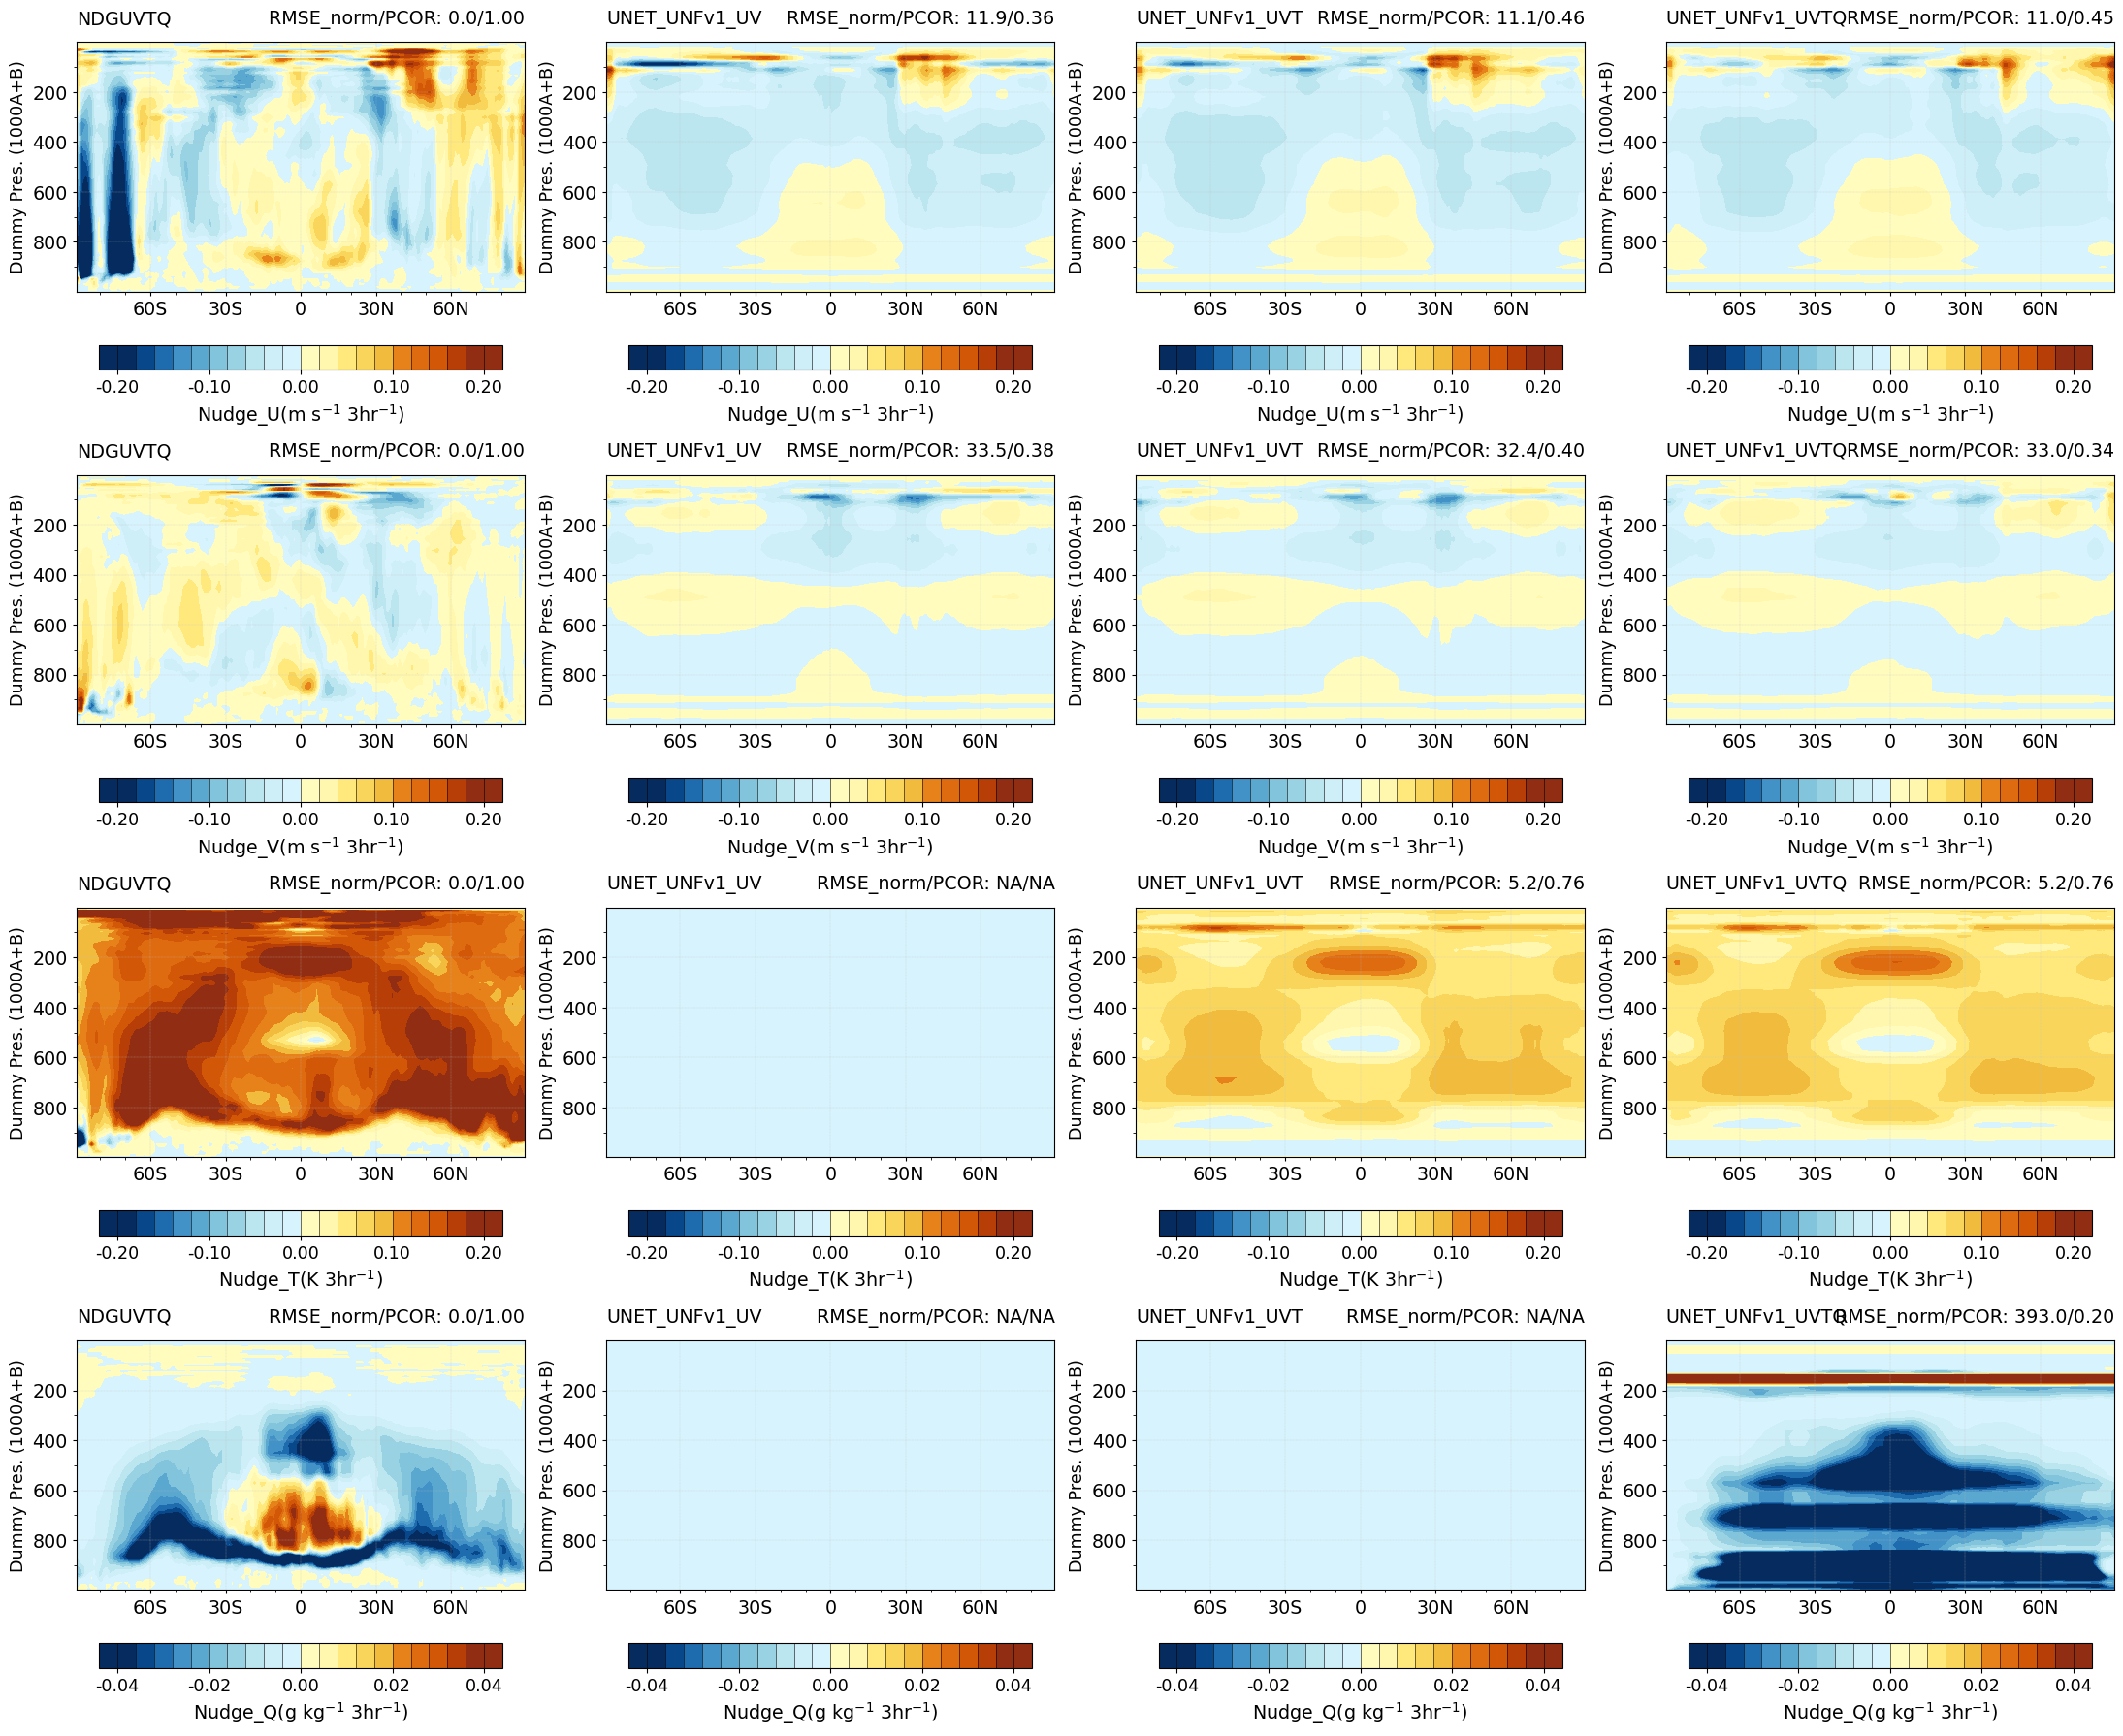

In [16]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_UNFv1" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_UNFv1" 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_UNFv2 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_UNFv2_UV
Nudge_U UNET_UNFv2_UVT
Nudge_U UNET_UNFv2_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_UNFv2_UV
Nudge_V UNET_UNFv2_UVT
Nudge_V UNET_UNFv2_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_UNFv2_UV
Nudge_T UNET_UNFv2_UVT
Nudge_T UNET_UNFv2_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_UNFv2_UV
Nudge_Q UNET_UNFv2_UVT
Nudge_Q UNET_UNFv2_UVTQ


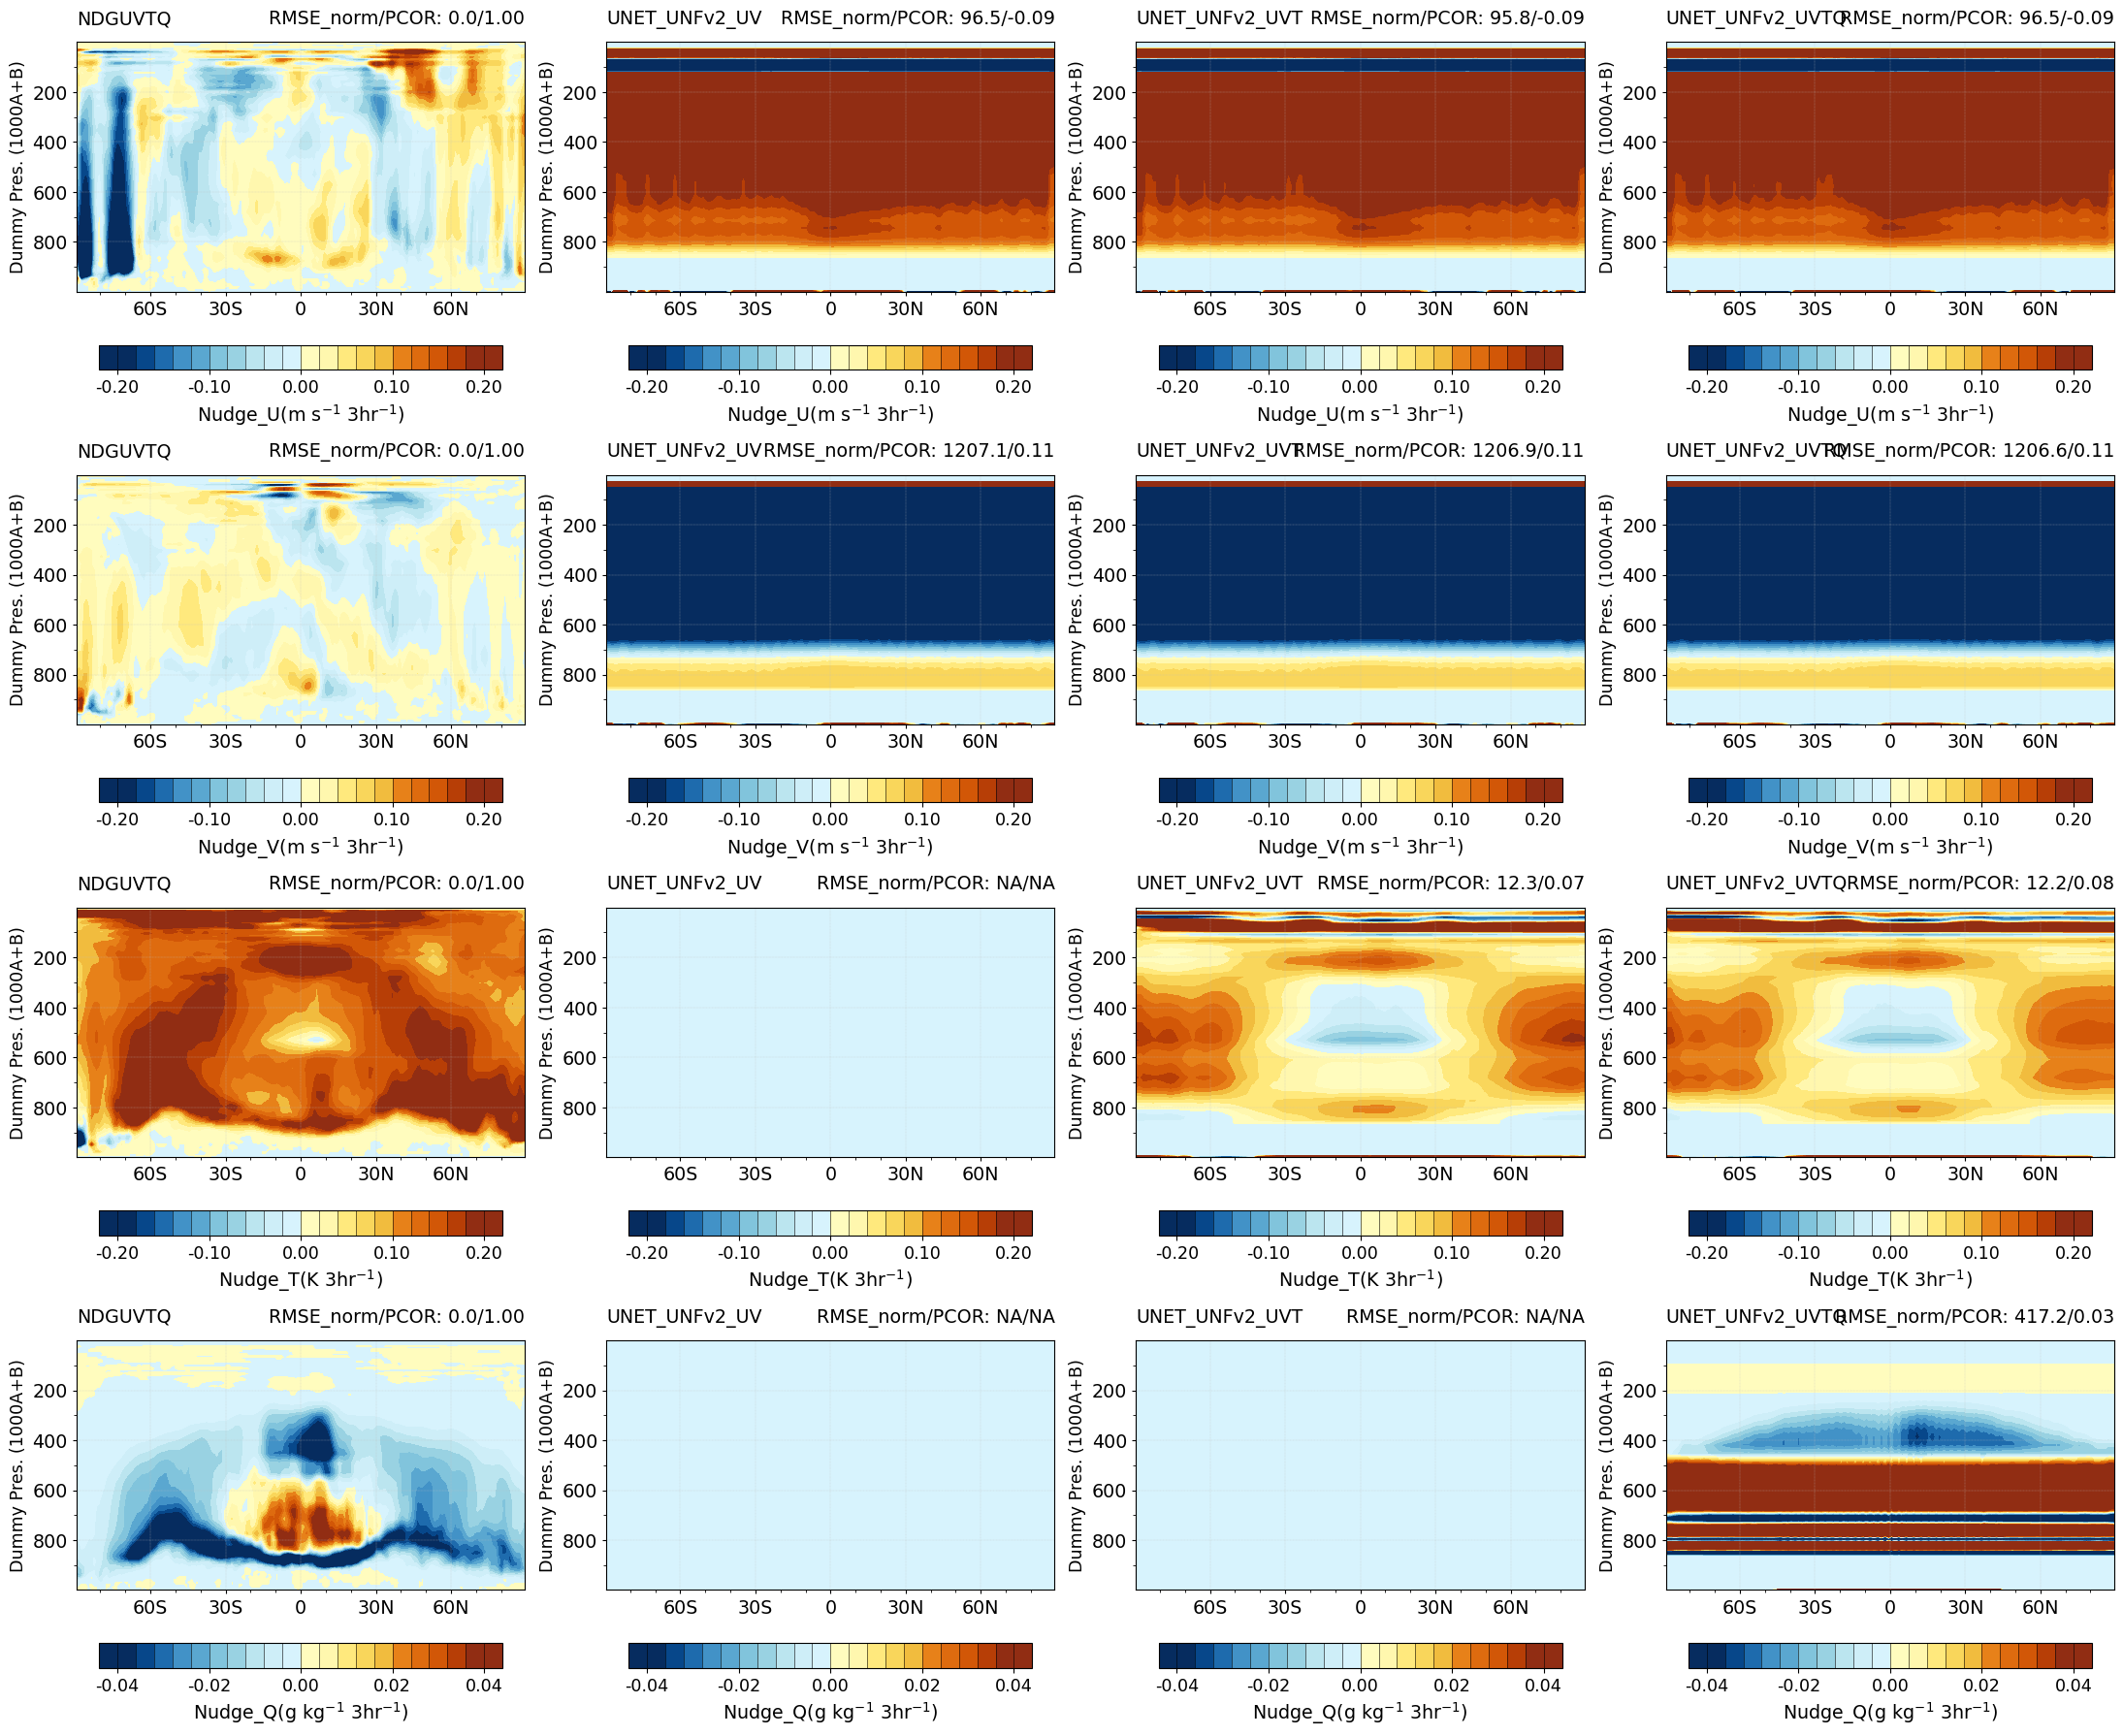

In [17]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mtag  = "UNET{}_UNFv2" # u,v,t,q, no spacial treatment 
    exp_mstr  = "UNET_UNFv2" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_UNFv2.1 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_UNFv2.1_UV
Nudge_U UNET_UNFv2.1_UVT
Nudge_U UNET_UNFv2.1_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_UNFv2.1_UV
Nudge_V UNET_UNFv2.1_UVT
Nudge_V UNET_UNFv2.1_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_UNFv2.1_UV
Nudge_T UNET_UNFv2.1_UVT
Nudge_T UNET_UNFv2.1_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_UNFv2.1_UV
Nudge_Q UNET_UNFv2.1_UVT
Nudge_Q UNET_UNFv2.1_UVTQ


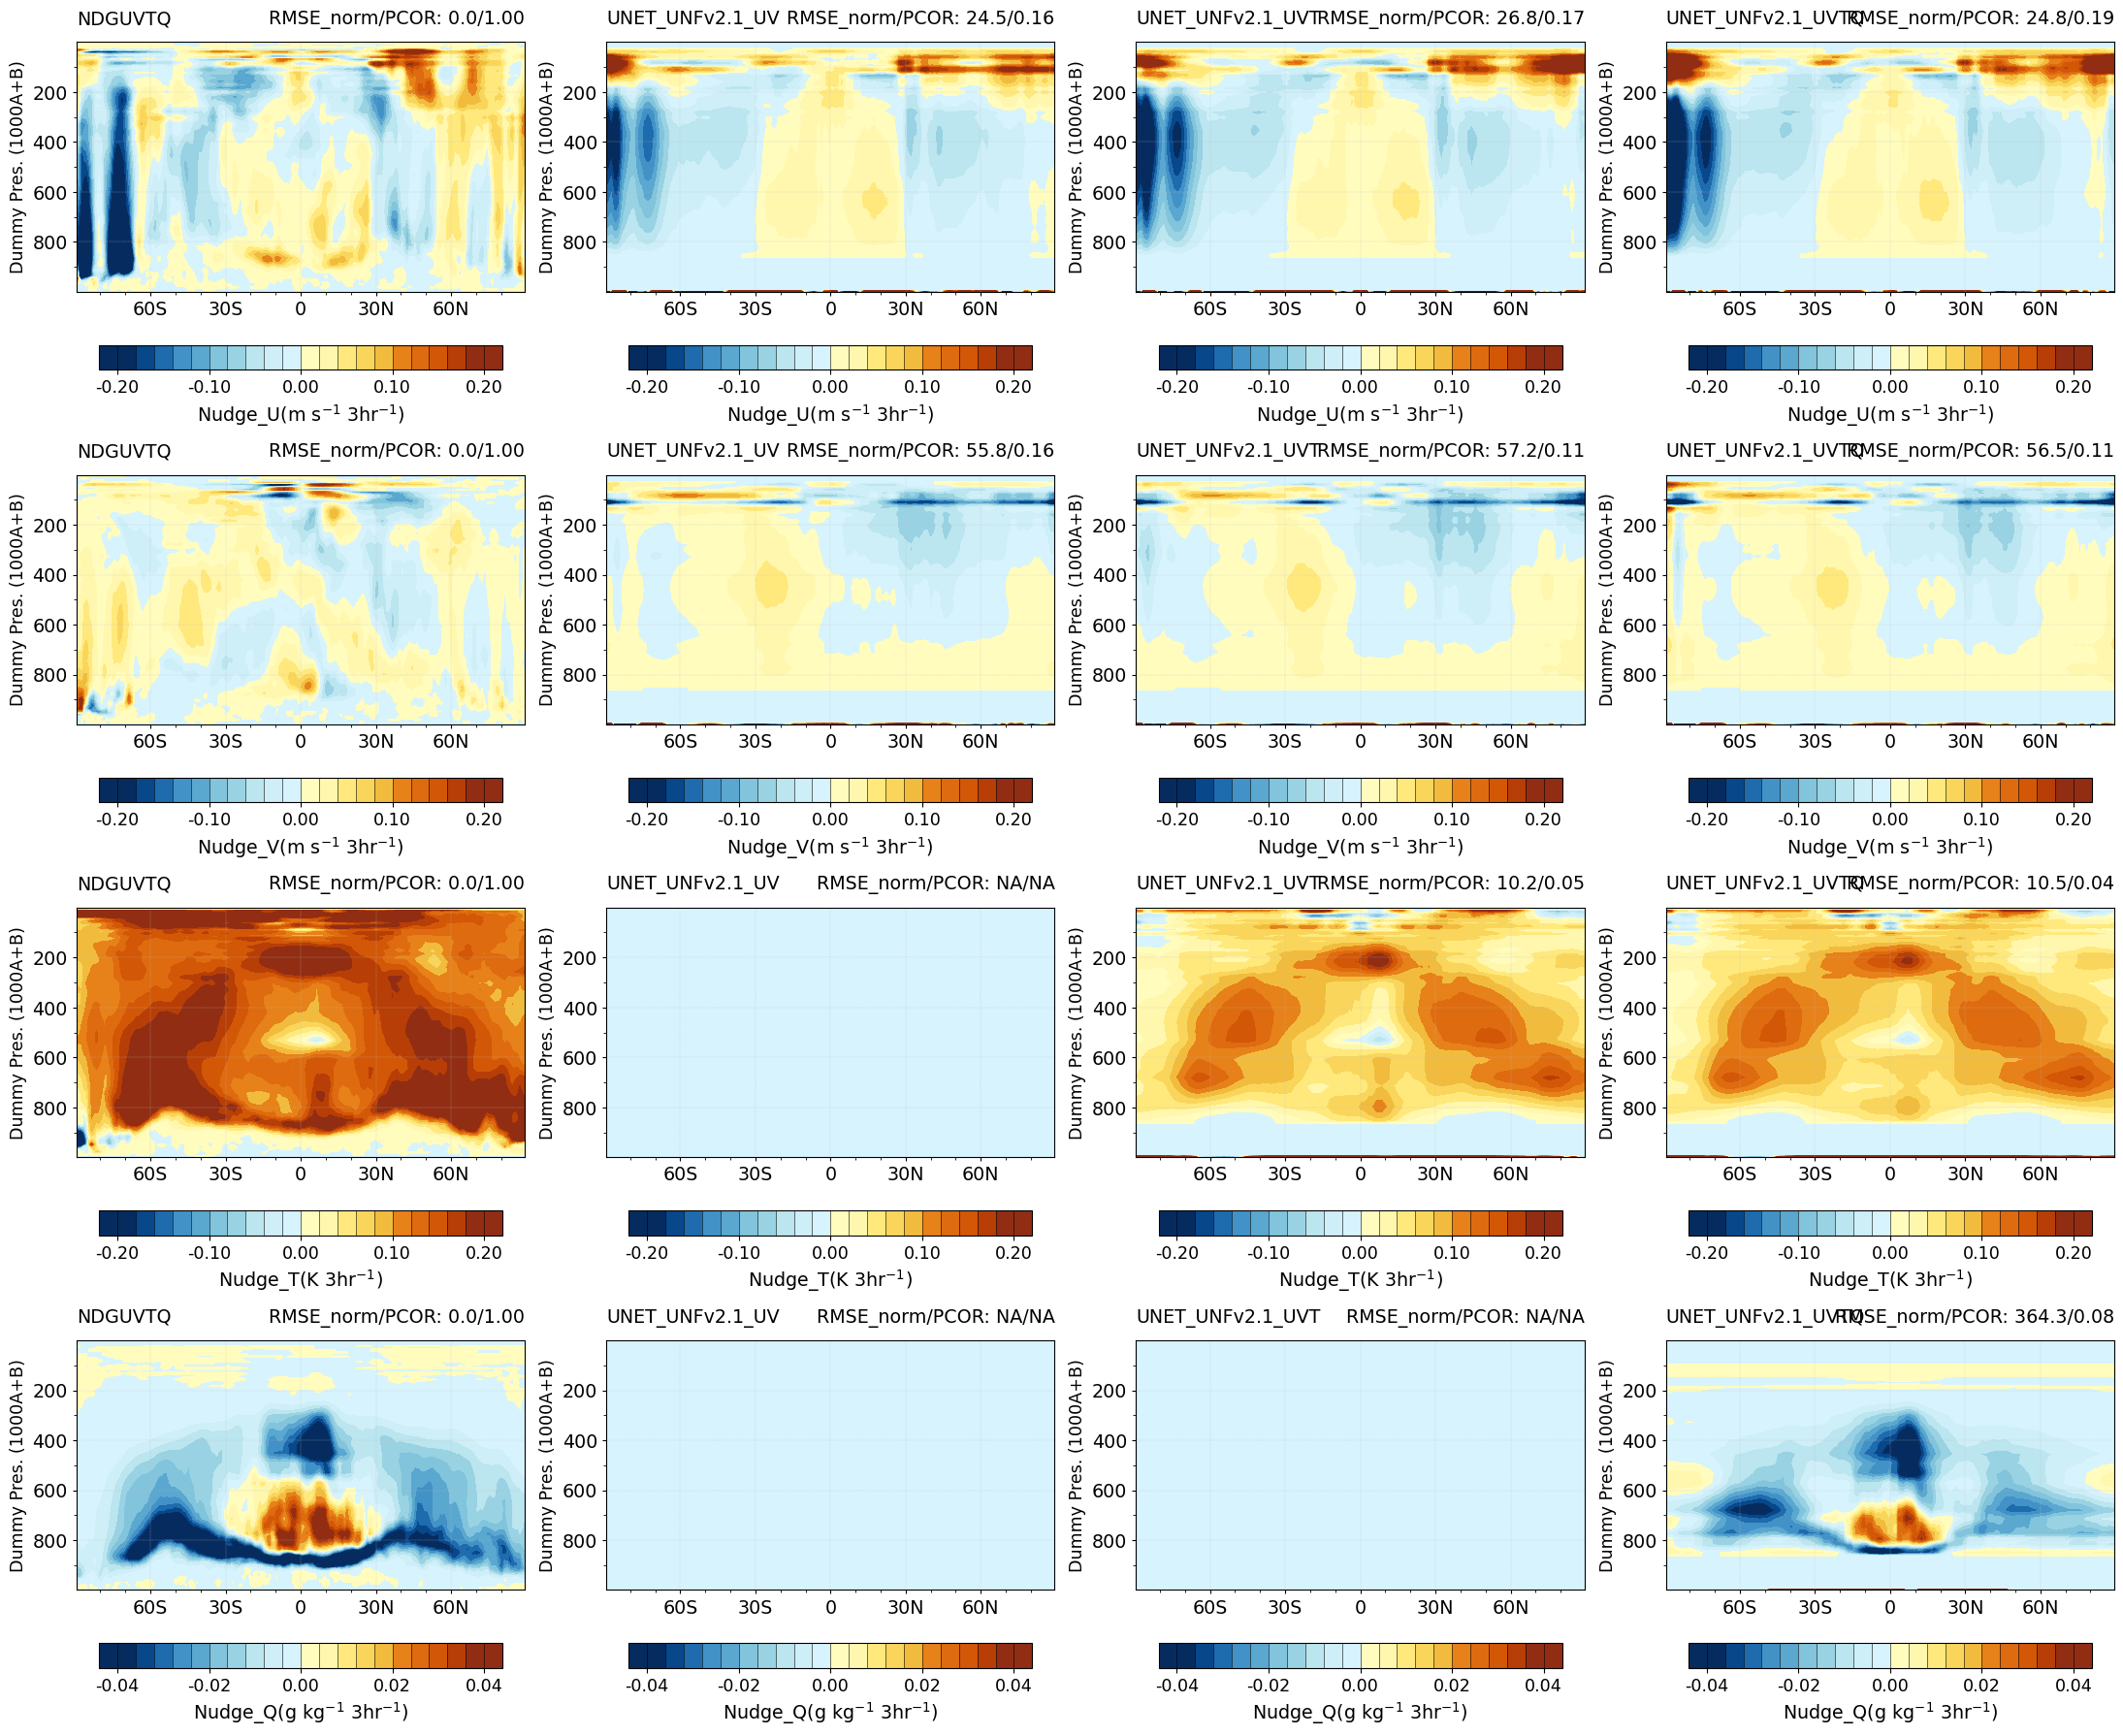

In [18]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_UNFv2.1" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_UNFv2.1" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_UNFv2.2 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_UNFv2.2_UV
Nudge_U UNET_UNFv2.2_UVT
Nudge_U UNET_UNFv2.2_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_UNFv2.2_UV
Nudge_V UNET_UNFv2.2_UVT
Nudge_V UNET_UNFv2.2_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_UNFv2.2_UV
Nudge_T UNET_UNFv2.2_UVT
Nudge_T UNET_UNFv2.2_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_UNFv2.2_UV
Nudge_Q UNET_UNFv2.2_UVT
Nudge_Q UNET_UNFv2.2_UVTQ


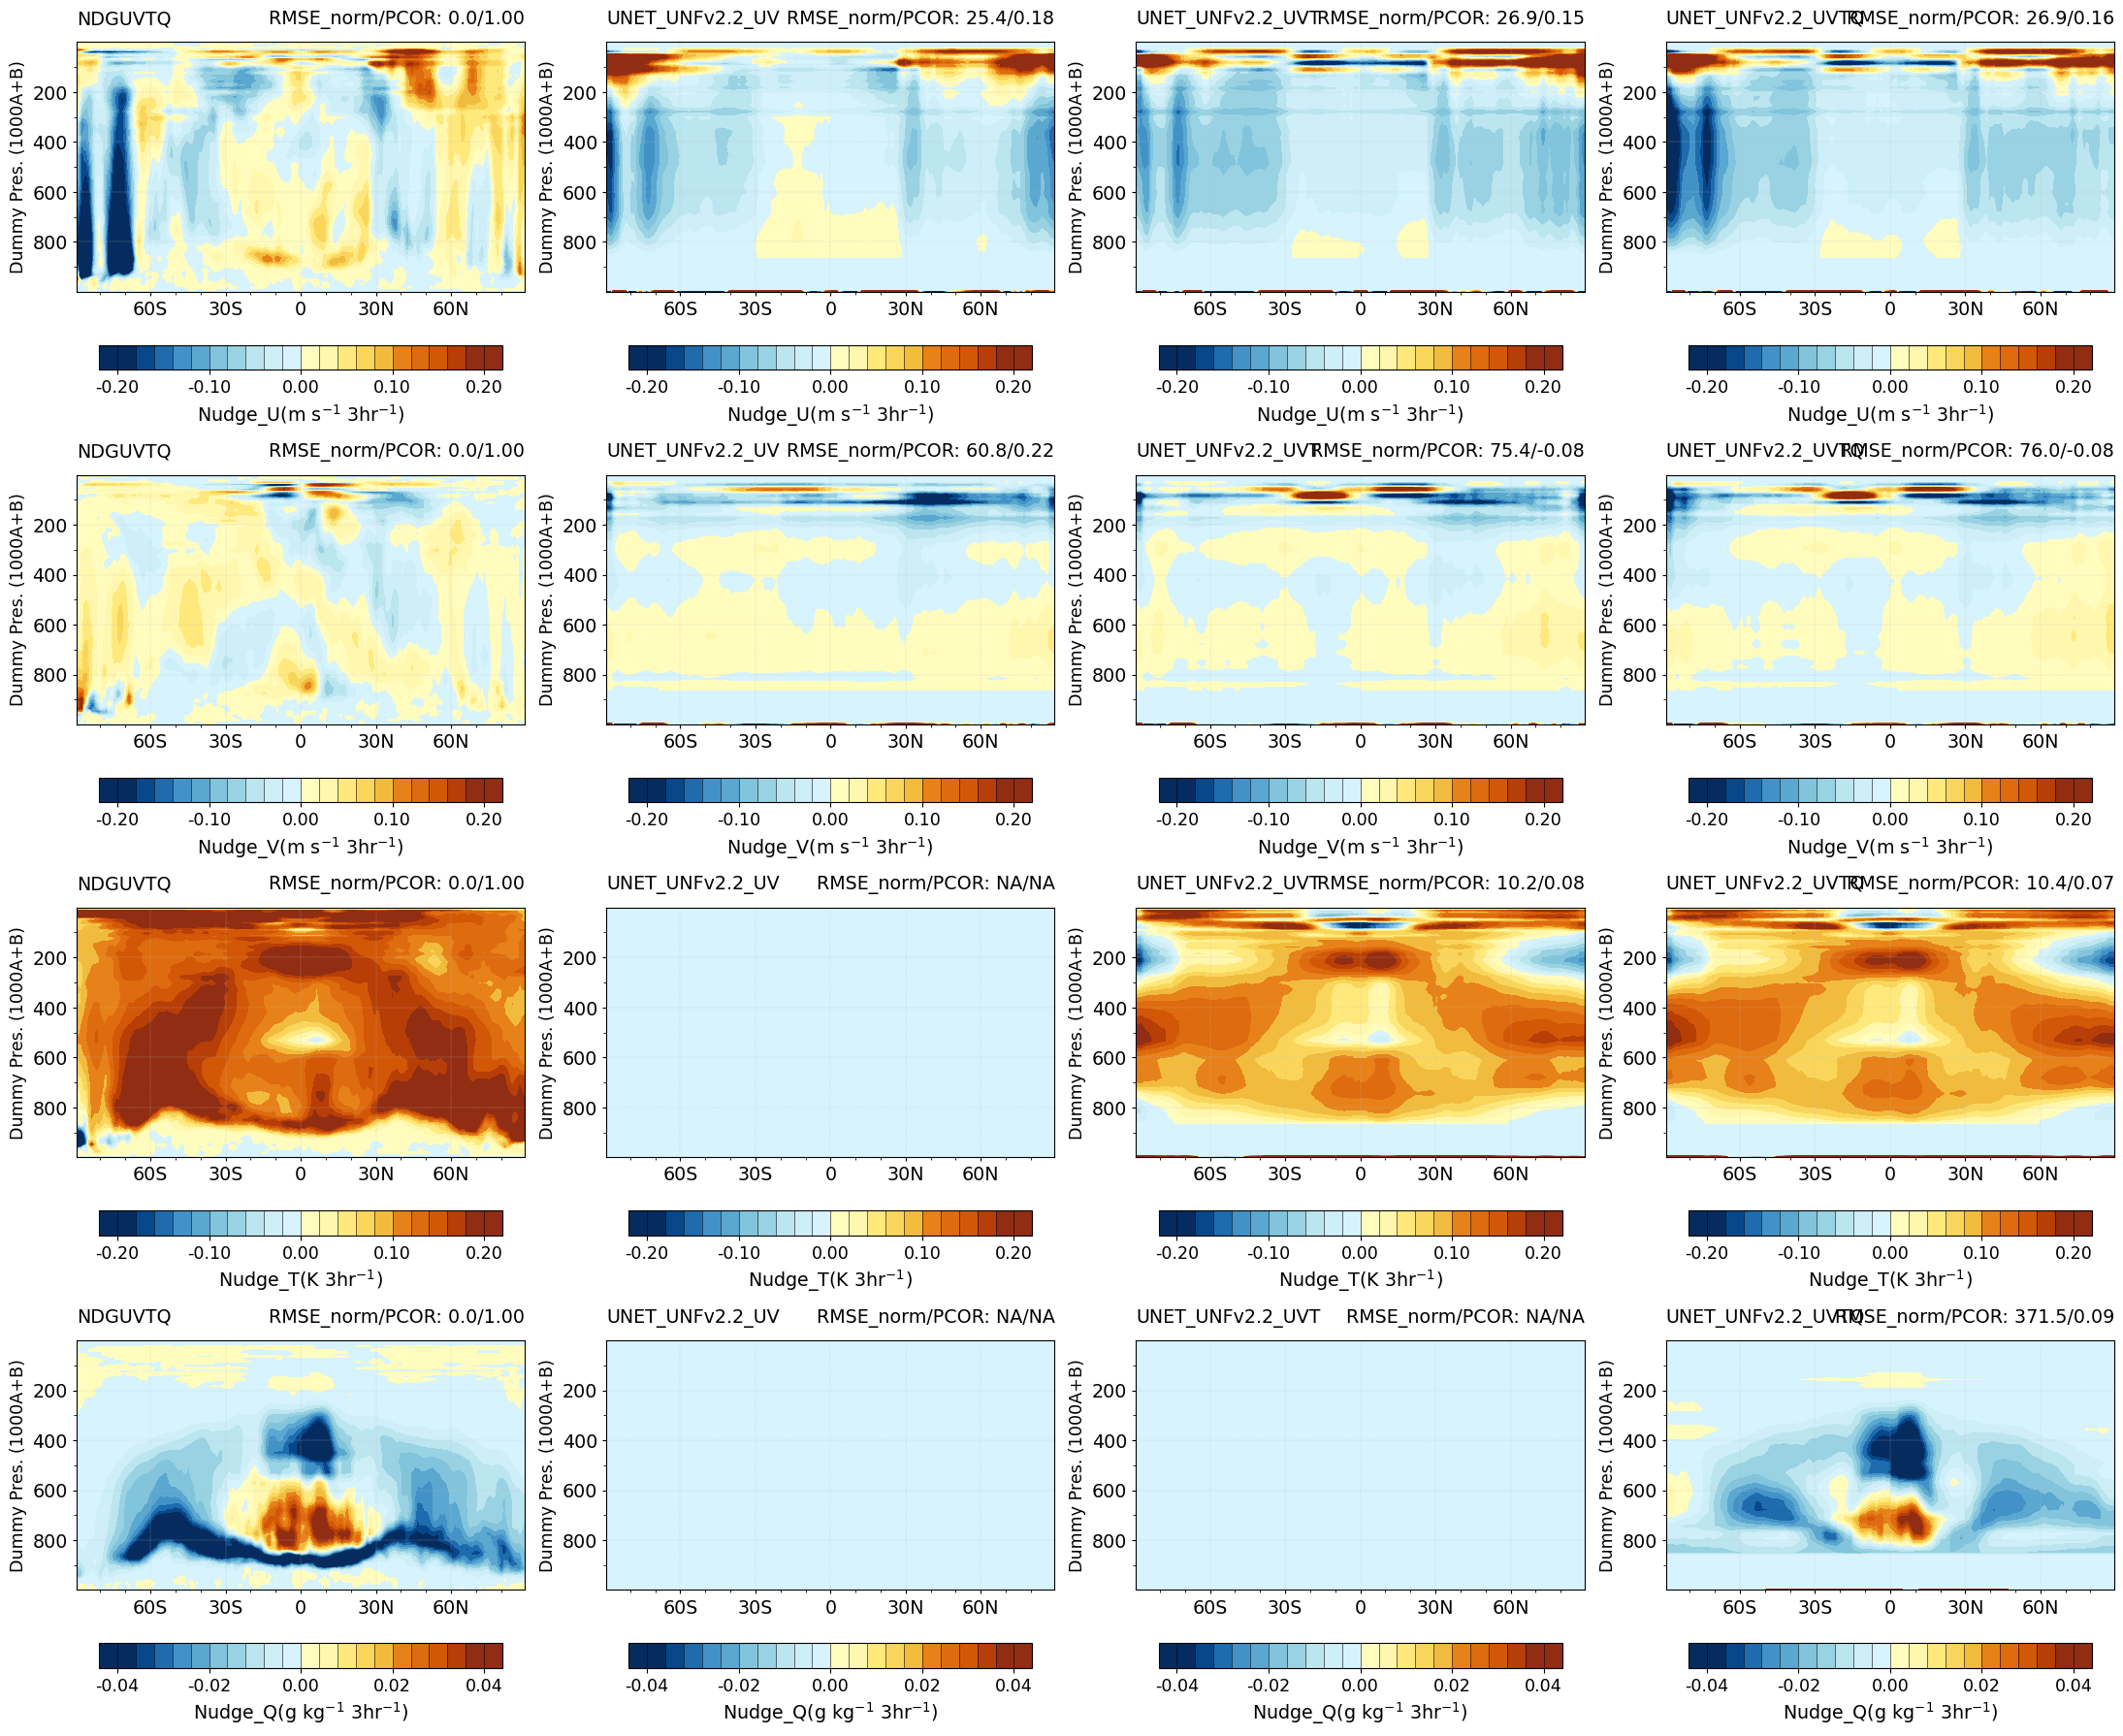

In [19]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_UNFv2.2" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_UNFv2.2" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 RUNET{}_UNFv0 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U RUNET_UNFv0_UV
Nudge_U RUNET_UNFv0_UVT
Nudge_U RUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V RUNET_UNFv0_UV
Nudge_V RUNET_UNFv0_UVT
Nudge_V RUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T RUNET_UNFv0_UV
Nudge_T RUNET_UNFv0_UVT
Nudge_T RUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q RUNET_UNFv0_UV
Nudge_Q RUNET_UNFv0_UVT
Nudge_Q RUNET_UNFv0_UVTQ


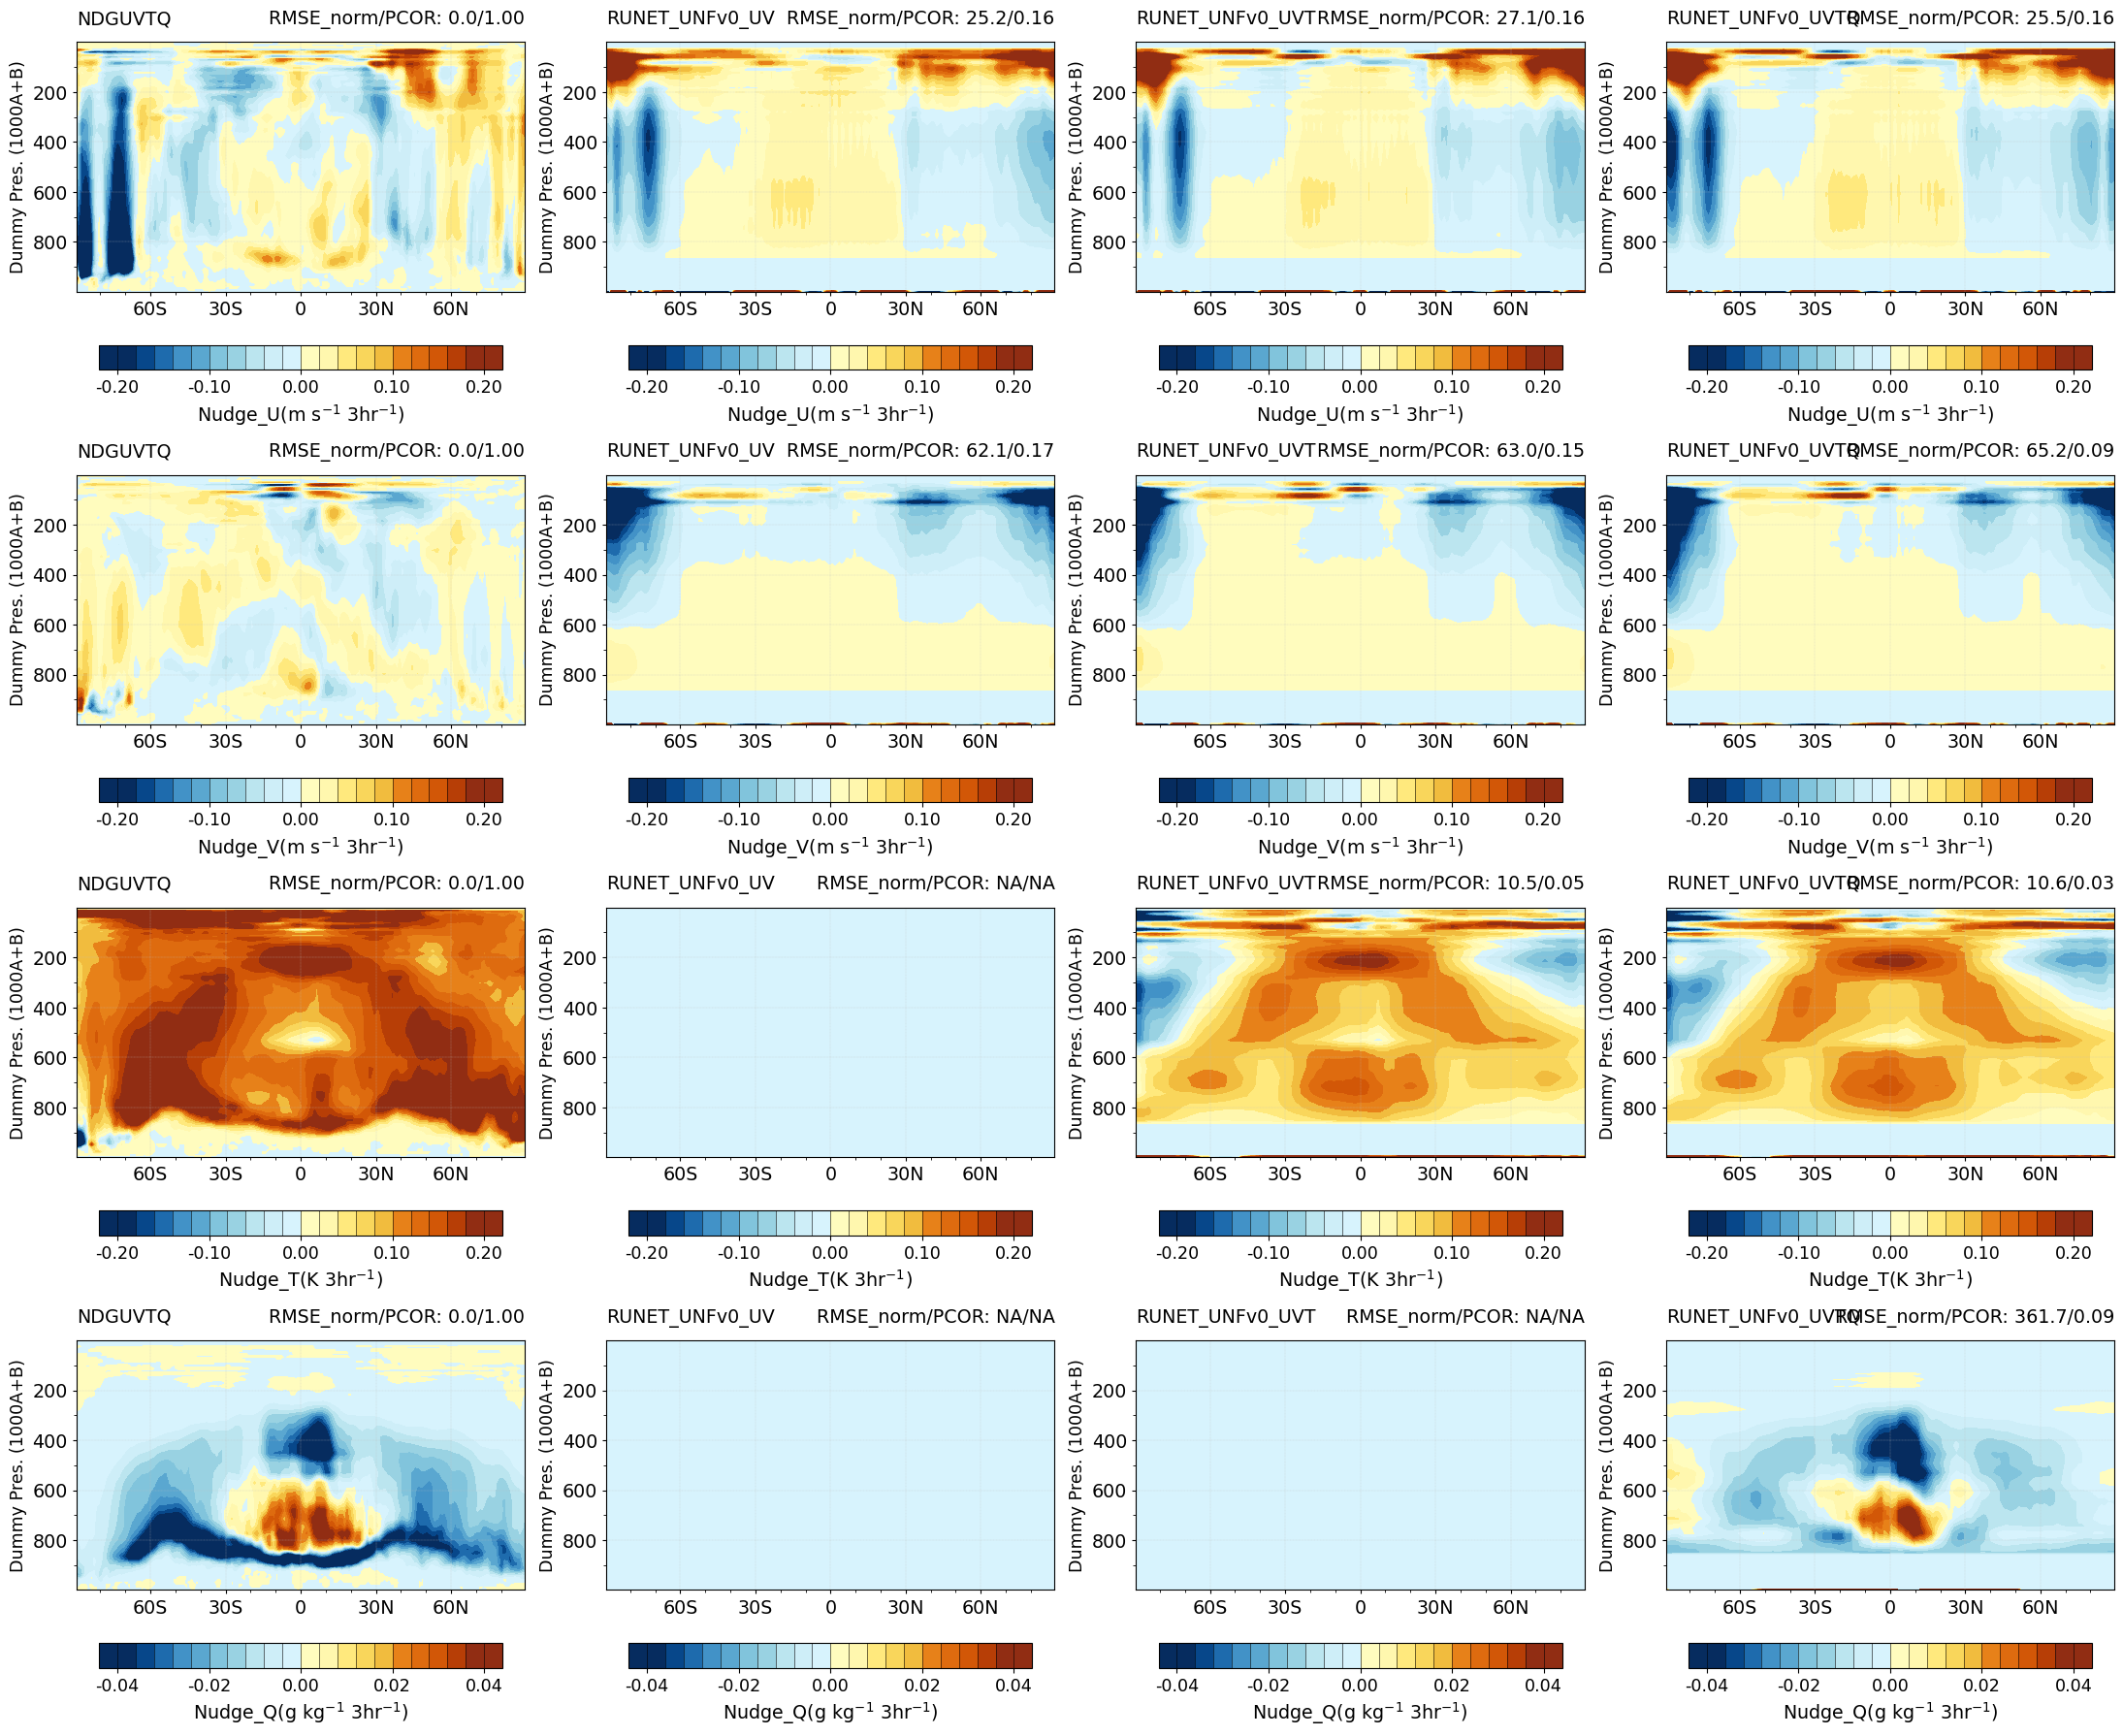

In [20]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "RUNET_UNFv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "RUNET{}_UNFv0" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    


working on  Sandy 2012 IUNET{}_UNFv0 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U IUNET_UNFv0_UV
Nudge_U IUNET_UNFv0_UVT
Nudge_U IUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V IUNET_UNFv0_UV
Nudge_V IUNET_UNFv0_UVT
Nudge_V IUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T IUNET_UNFv0_UV
Nudge_T IUNET_UNFv0_UVT
Nudge_T IUNET_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q IUNET_UNFv0_UV
Nudge_Q IUNET_UNFv0_UVT
Nudge_Q IUNET_UNFv0_UVTQ


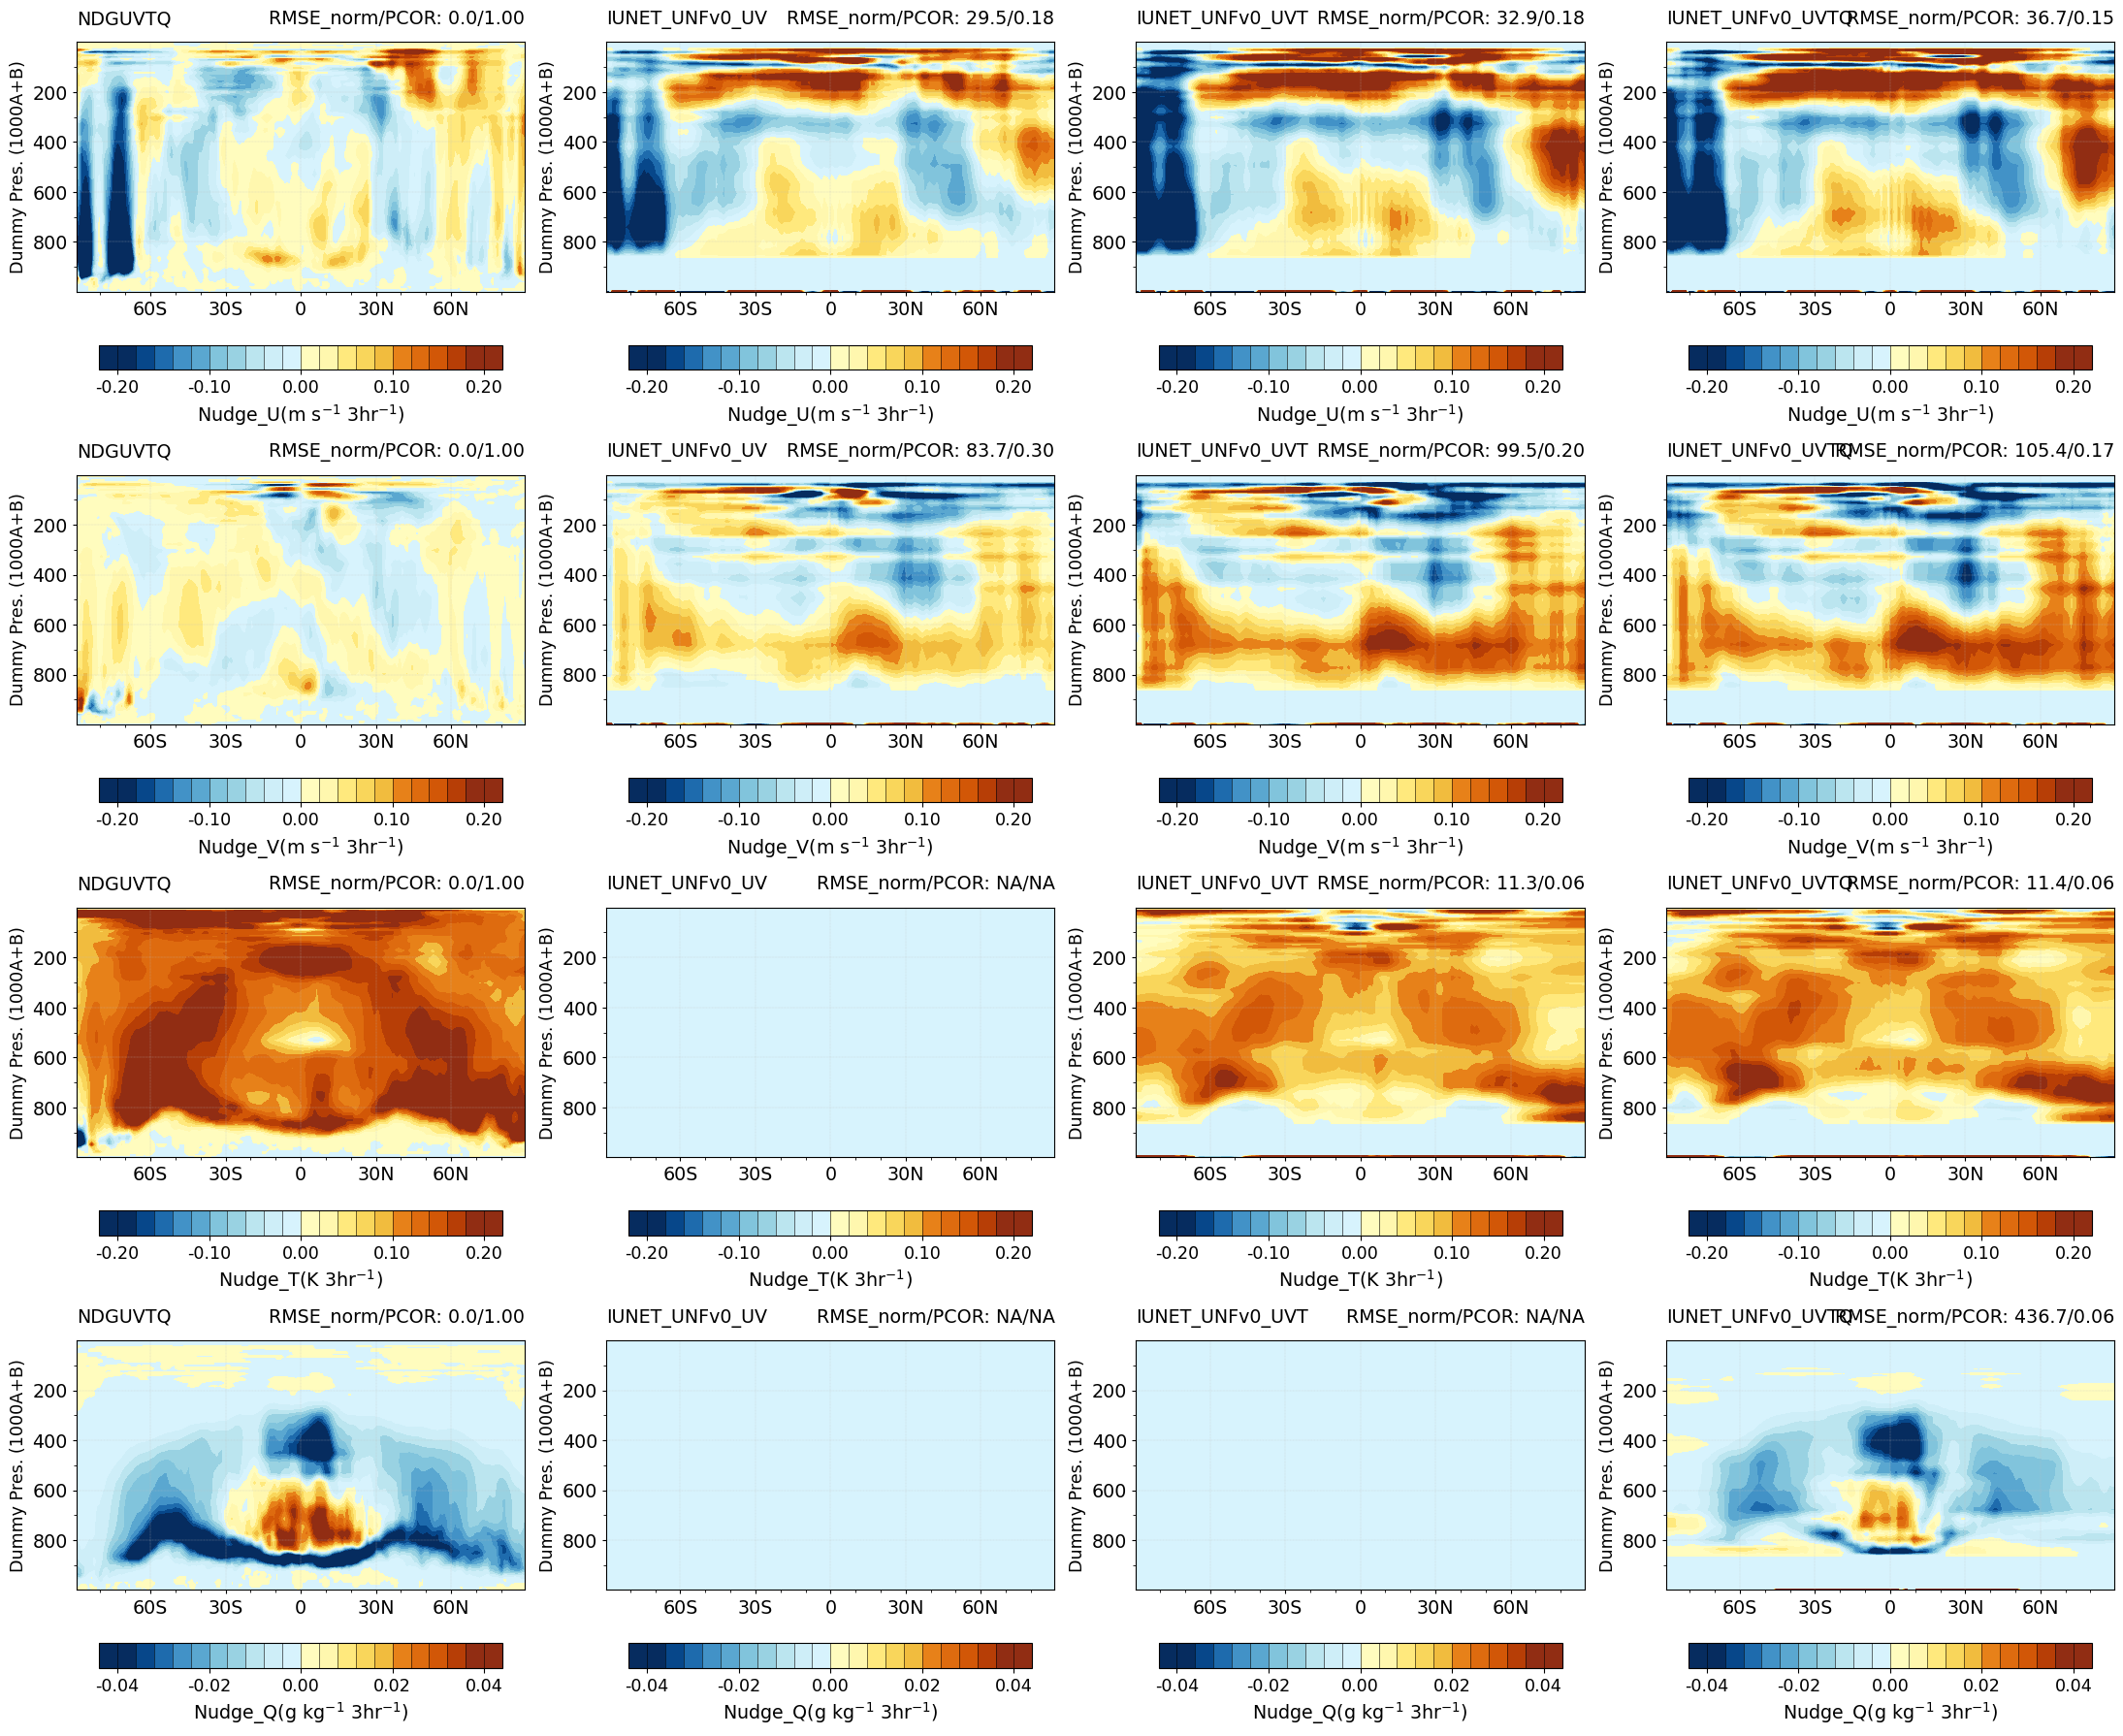

In [21]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "IUNET_UNFv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "IUNET{}_UNFv0" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{} 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_SEPv0_UV
Nudge_U UNET_SEPv0_UVT
Nudge_U UNET_SEPv0_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_SEPv0_UV
Nudge_V UNET_SEPv0_UVT
Nudge_V UNET_SEPv0_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_SEPv0_UV
Nudge_T UNET_SEPv0_UVT
Nudge_T UNET_SEPv0_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_SEPv0_UV
Nudge_Q UNET_SEPv0_UVT
Nudge_Q UNET_SEPv0_UVTQ


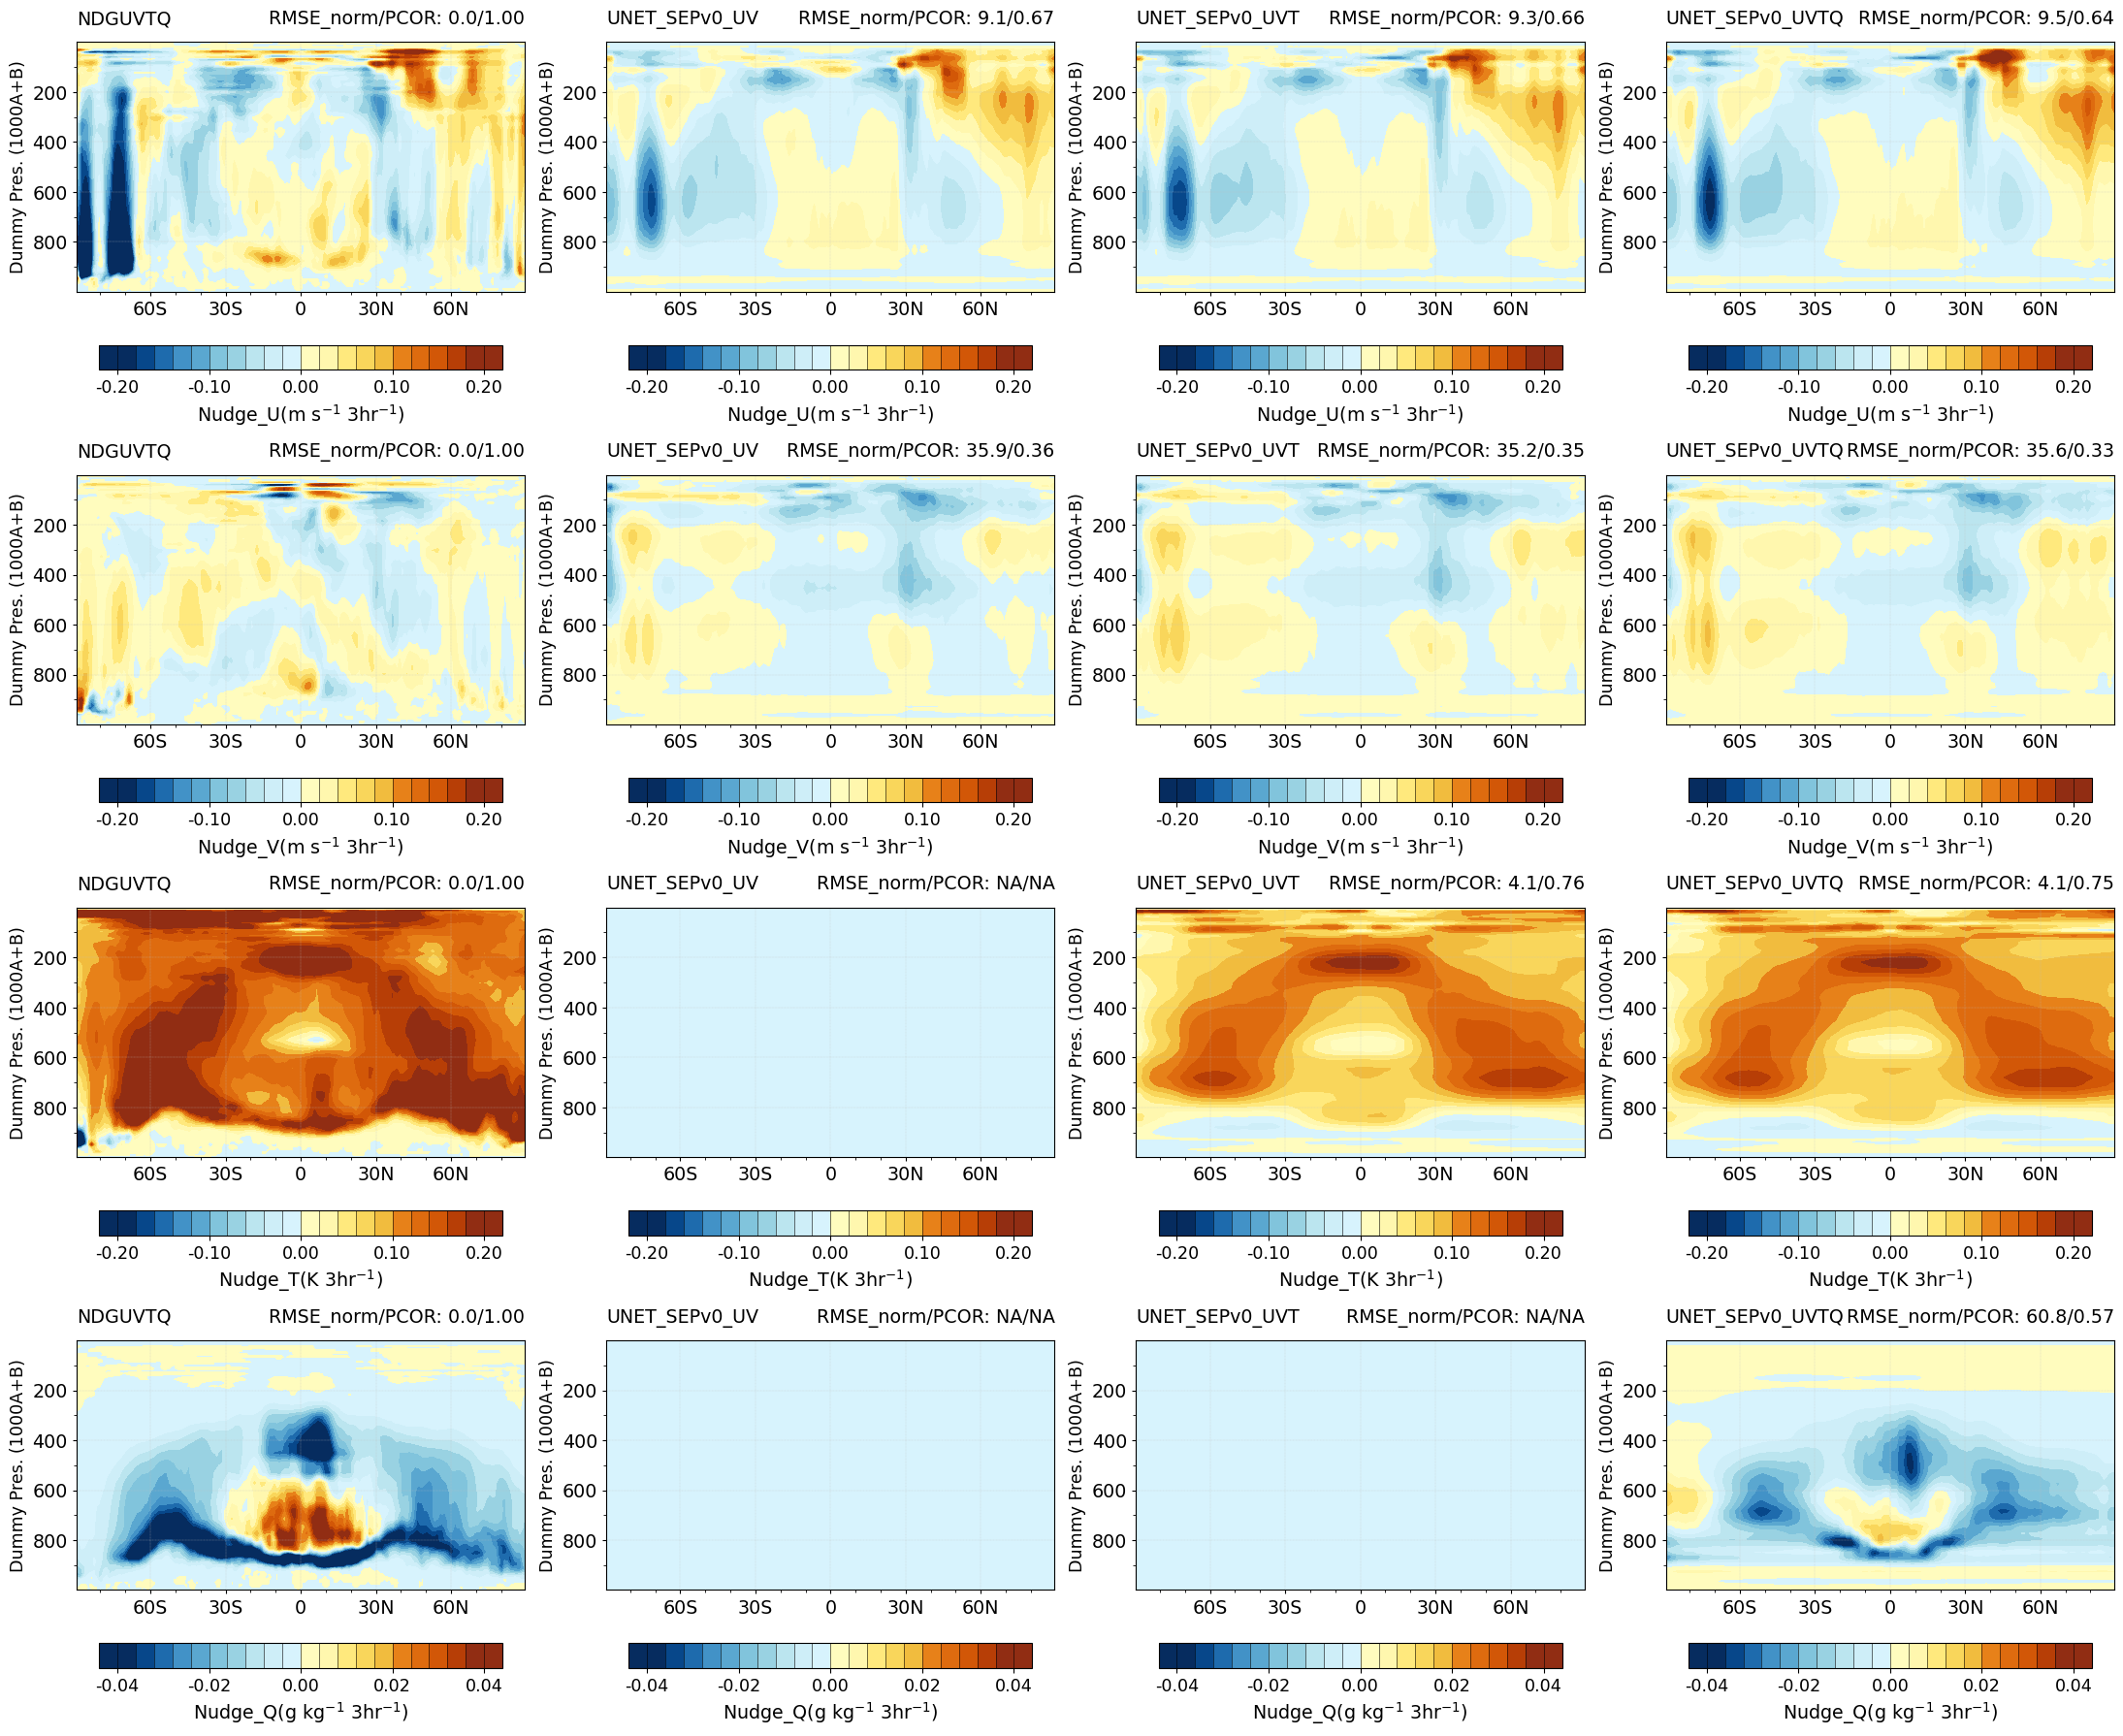

In [22]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_SEPv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_Layer 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_Layer_UV
Nudge_U UNET_Layer_UVT
Nudge_U UNET_Layer_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_Layer_UV
Nudge_V UNET_Layer_UVT
Nudge_V UNET_Layer_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_Layer_UV
Nudge_T UNET_Layer_UVT
Nudge_T UNET_Layer_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_Layer_UV
Nudge_Q UNET_Layer_UVT
Nudge_Q UNET_Layer_UVTQ


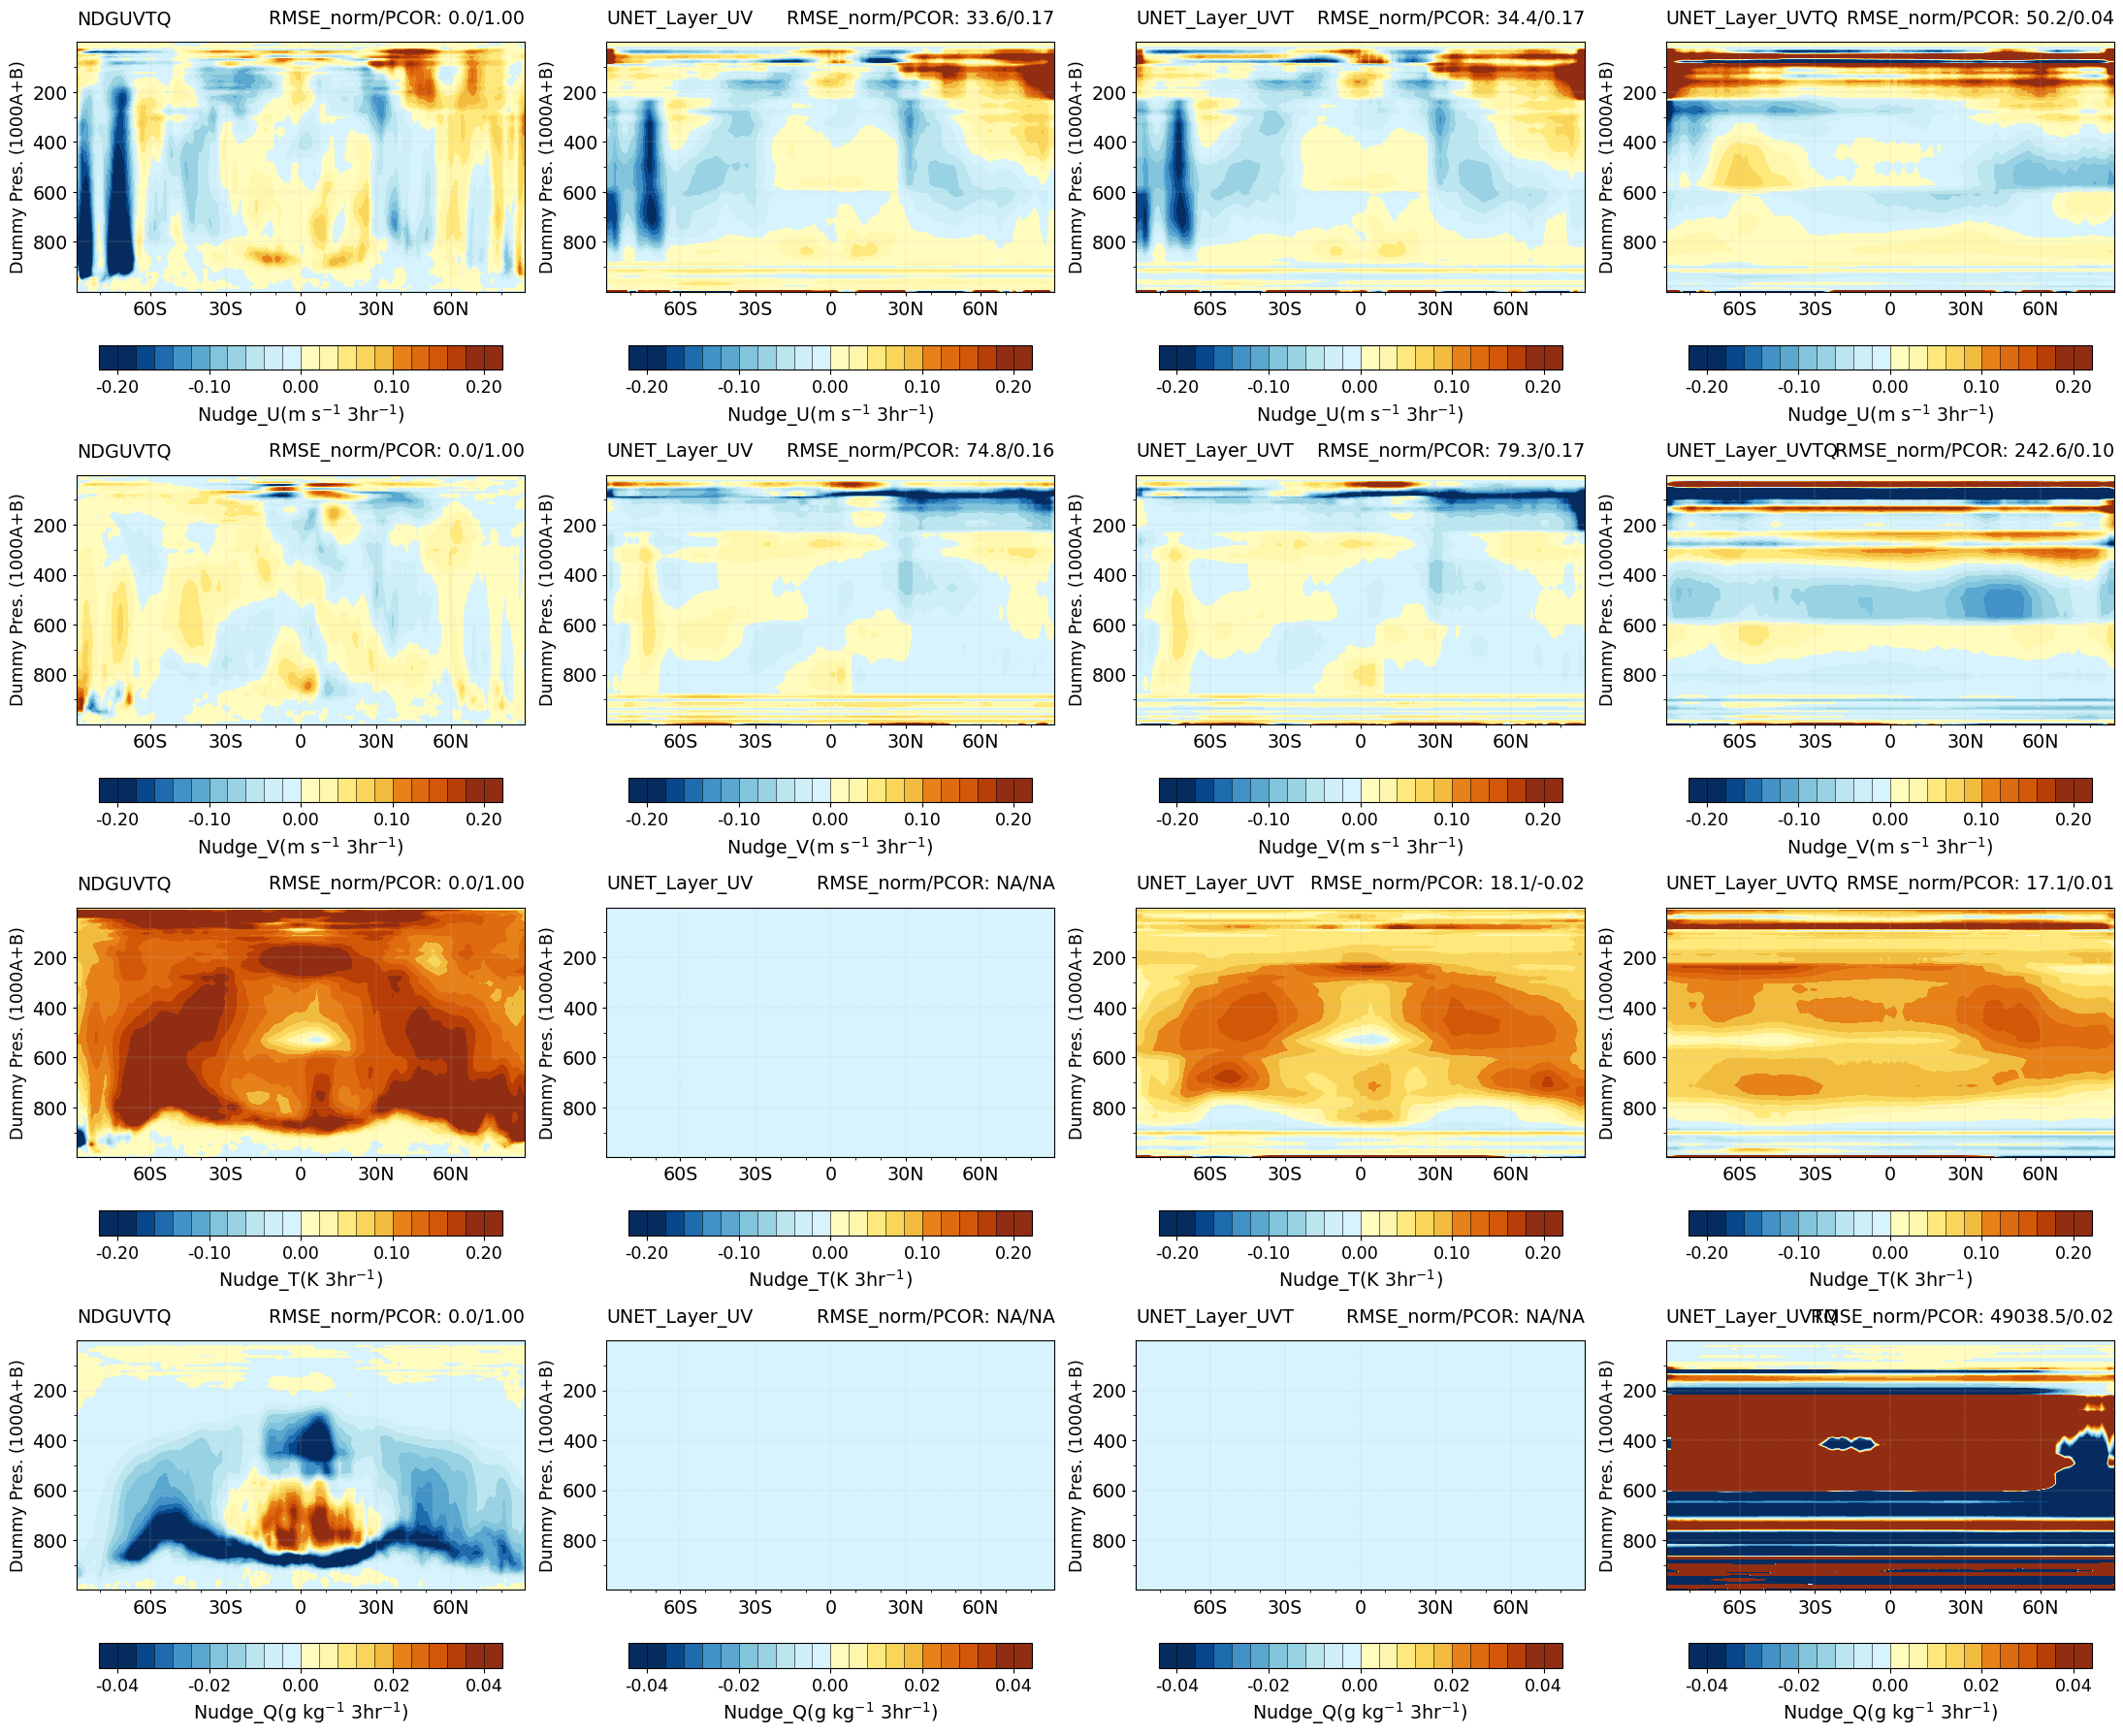

In [23]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_Layer" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_Layer" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 UNET{}_SCALv0 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U UNET_SCALv0_UV
Nudge_U UNET_SCALv0_UVT
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V UNET_SCALv0_UV
Nudge_V UNET_SCALv0_UVT
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T UNET_SCALv0_UV
Nudge_T UNET_SCALv0_UVT
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q UNET_SCALv0_UV
Nudge_Q UNET_SCALv0_UVT


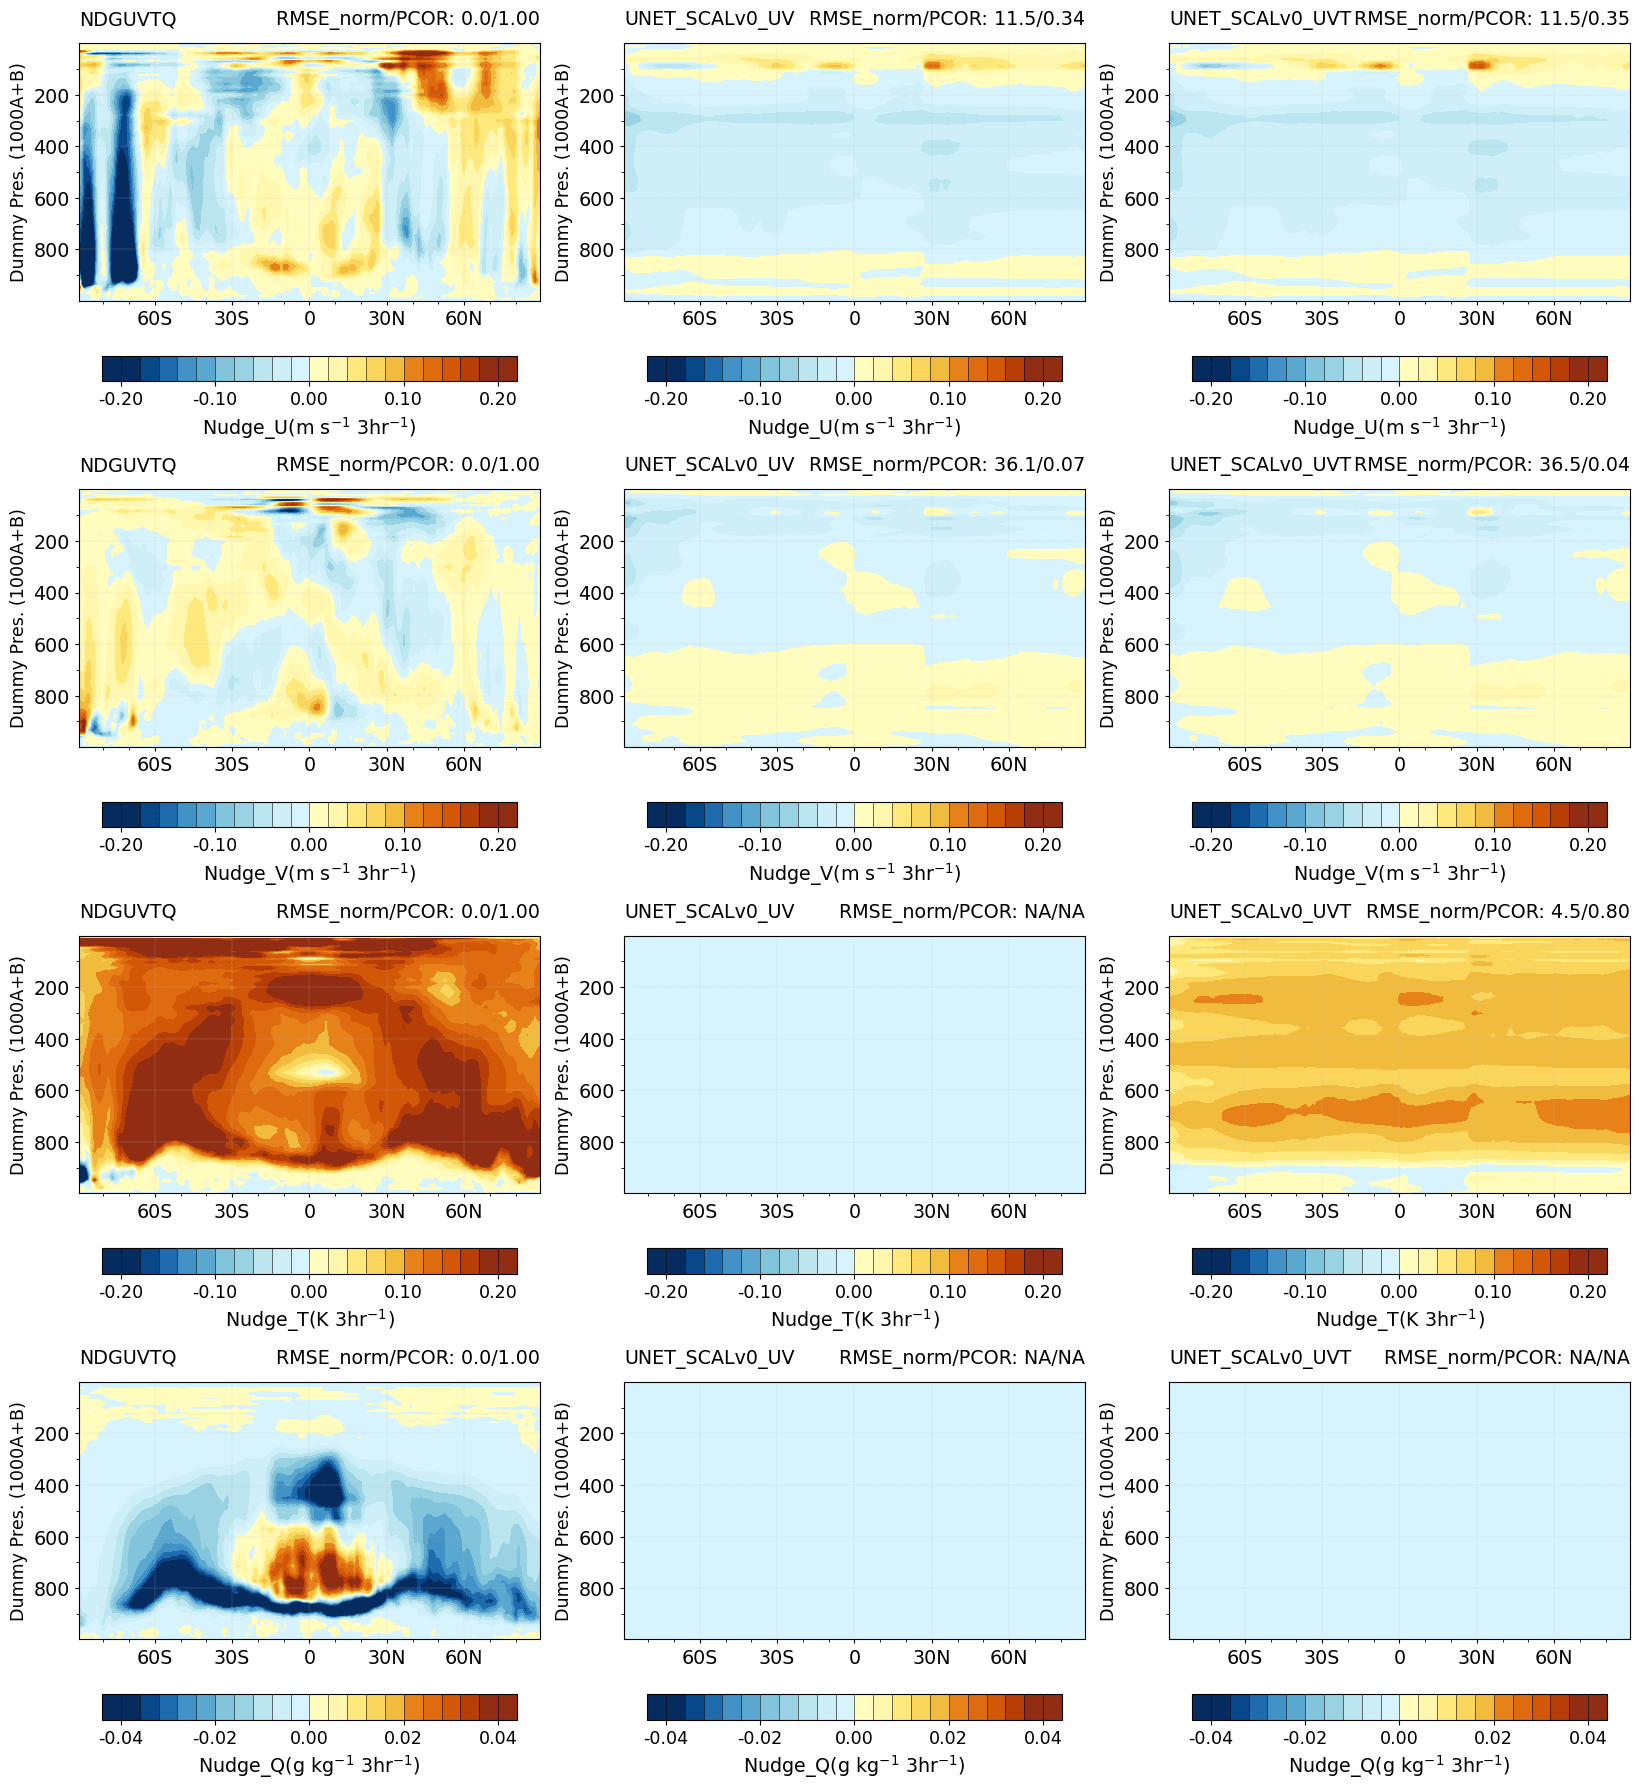

In [24]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "UNET_SCALv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "UNET{}_SCALv0" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 #'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 VITO{} 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U VITO_UNFv0_UV
Nudge_U VITO_UNFv0_UVT
Nudge_U VITO_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V VITO_UNFv0_UV
Nudge_V VITO_UNFv0_UVT
Nudge_V VITO_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T VITO_UNFv0_UV
Nudge_T VITO_UNFv0_UVT
Nudge_T VITO_UNFv0_UVTQ
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q VITO_UNFv0_UV
Nudge_Q VITO_UNFv0_UVT
Nudge_Q VITO_UNFv0_UVTQ


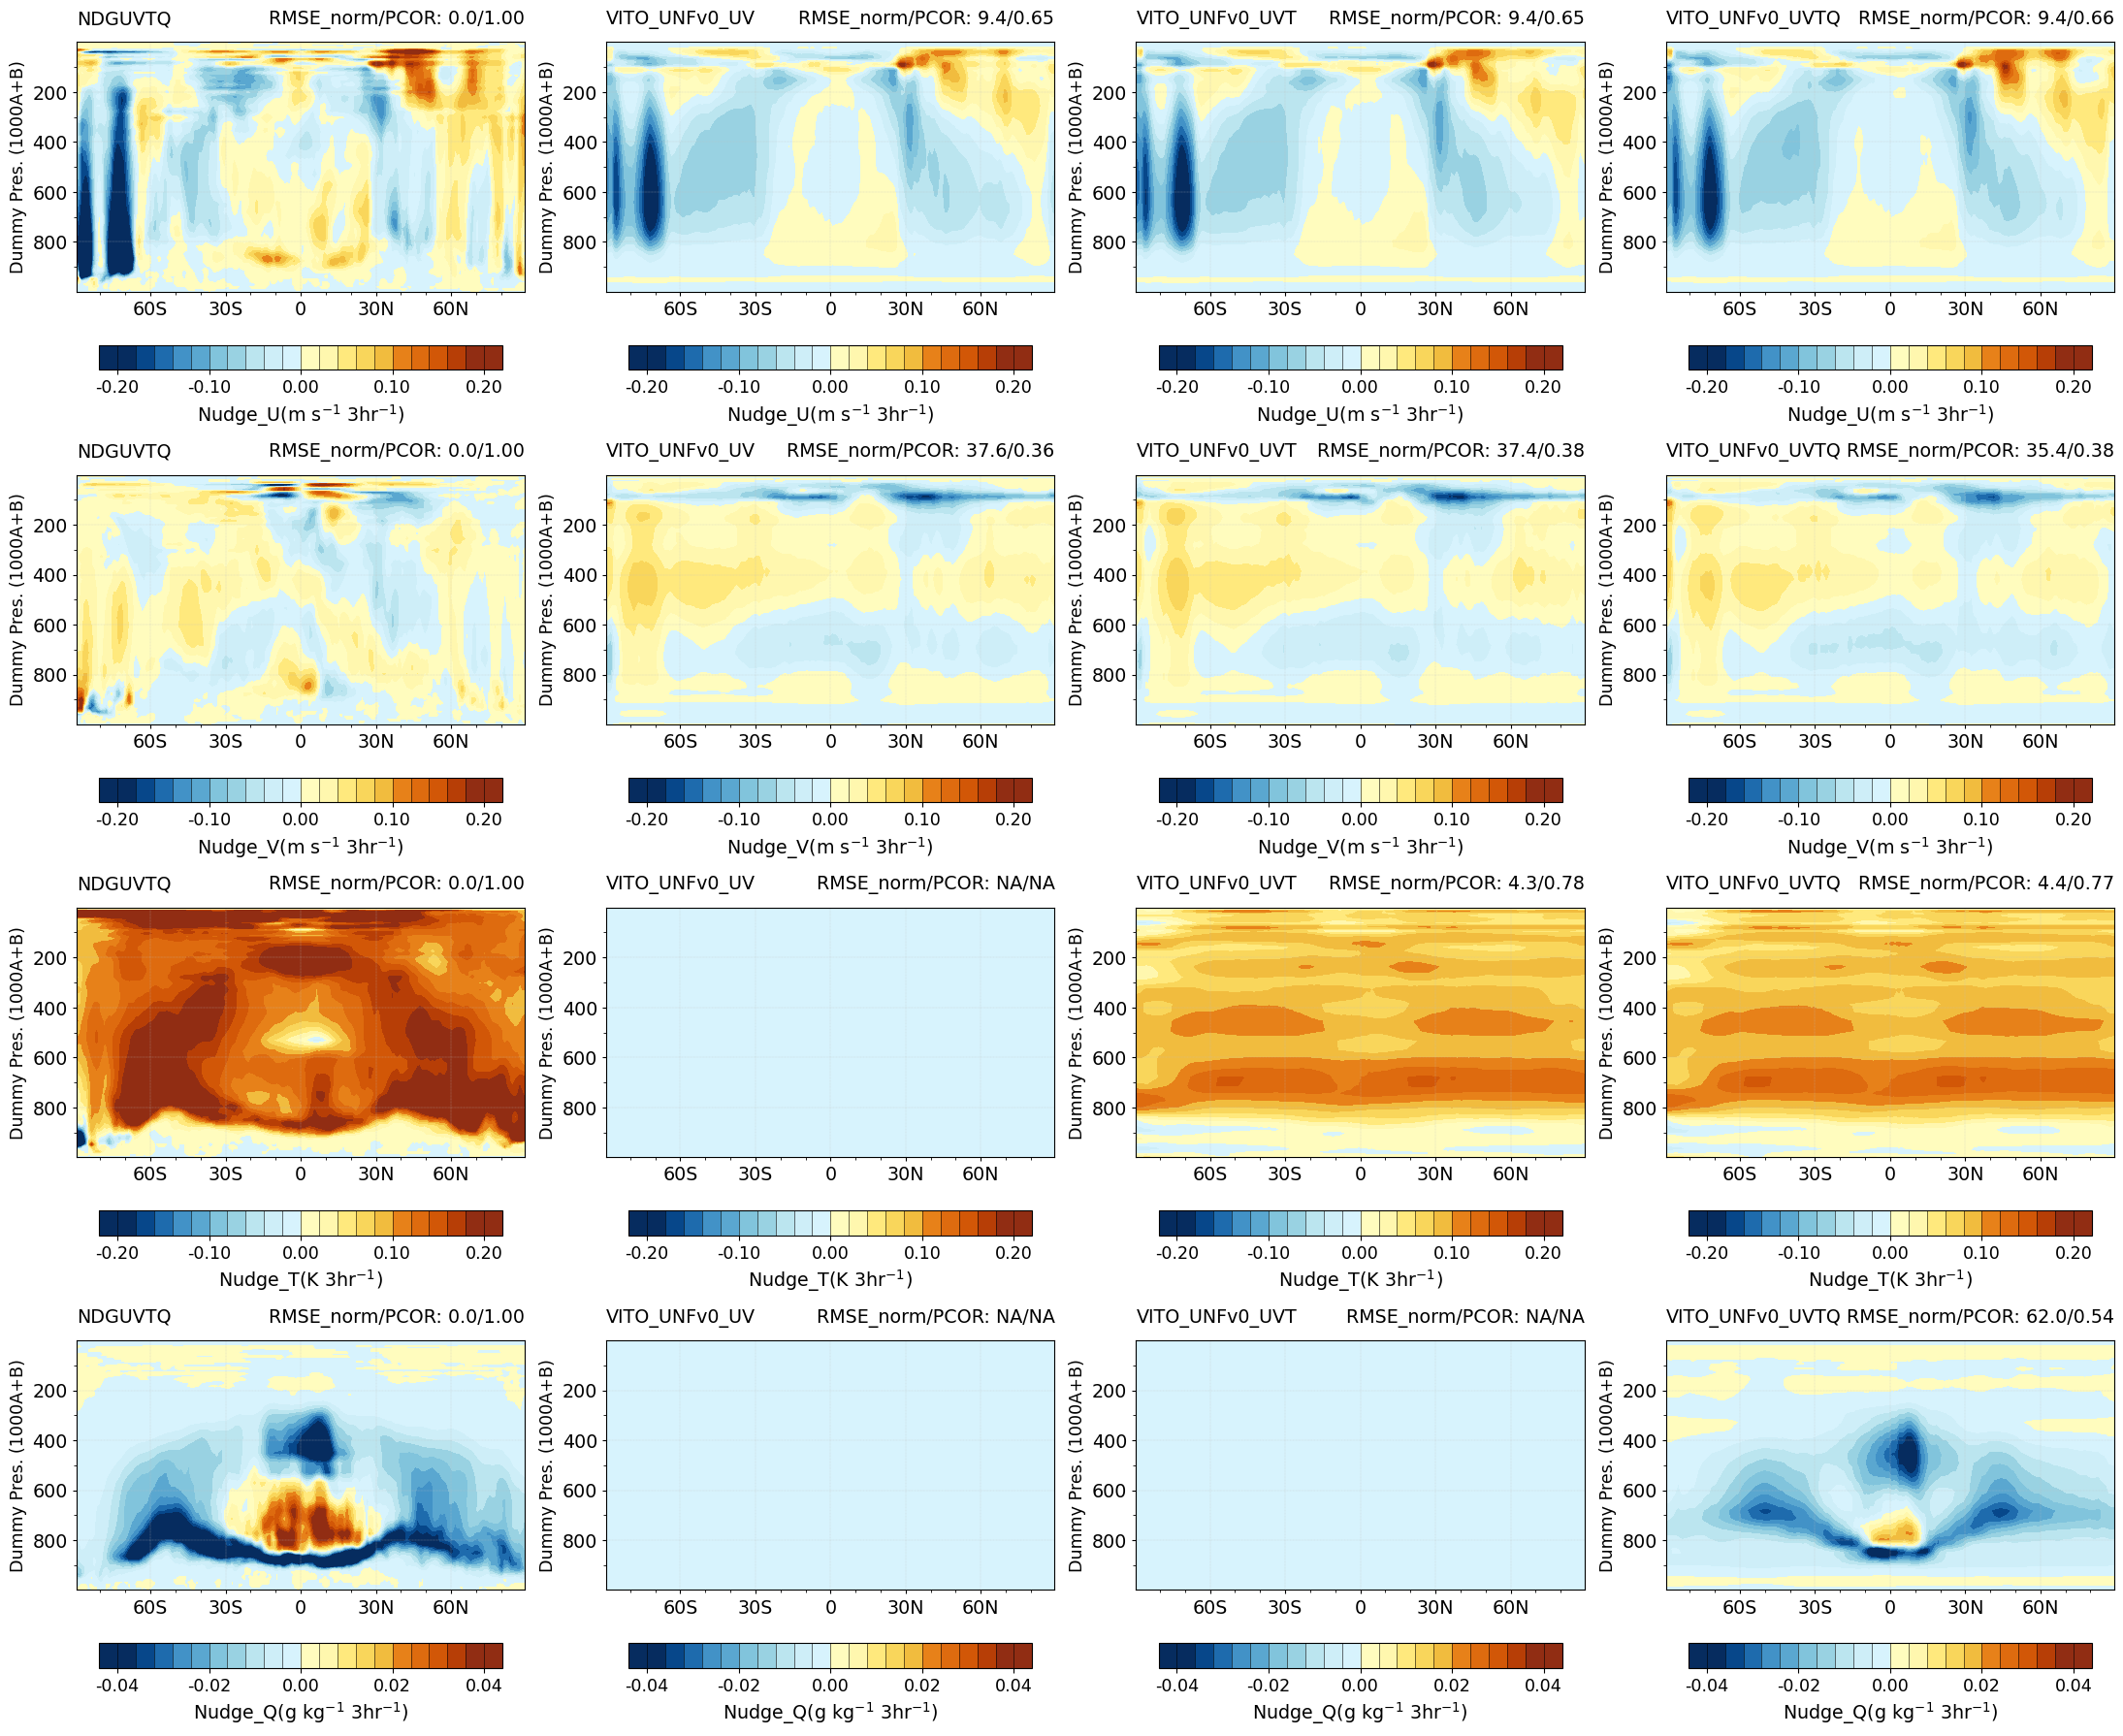

In [25]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "VITO_UNFv0" # u,v,t,q, no spacial treatment 
    exp_mtag  = "VITO{}" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':                            'NDGUVTQ',
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UV')):   '{}_{}'.format(exp_mstr,'UV'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVT')):  '{}_{}'.format(exp_mstr,'UVT'),
                 'SANDY2012_{}_F20TR_ne30pg2_EC30to60E2r2_pm-cpu'.format(exp_mtag.format('UVTQ')): '{}_{}'.format(exp_mstr,'UVTQ')
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    

working on  Sandy 2012 NDG{} 2012-10-22-2012-11-05
obs: <xarray.DataArray 'Nudge_U' ()> Size: 4B
array(0.00425172, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_U NDGUVTQ
Nudge_U NDGUV
Nudge_U NDGUVT
obs: <xarray.DataArray 'Nudge_V' ()> Size: 4B
array(0.00103716, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_V NDGUVTQ
Nudge_V NDGUV
Nudge_V NDGUVT
obs: <xarray.DataArray 'Nudge_T' ()> Size: 4B
array(0.01814248, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_T NDGUVTQ
Nudge_T NDGUV
Nudge_T NDGUVT
obs: <xarray.DataArray 'Nudge_Q' ()> Size: 4B
array(0.00020342, dtype=float32)
Coordinates:
    time     object 8B 2012-10-29 00:00:00
Nudge_Q NDGUVTQ
Nudge_Q NDGUV
Nudge_Q NDGUVT


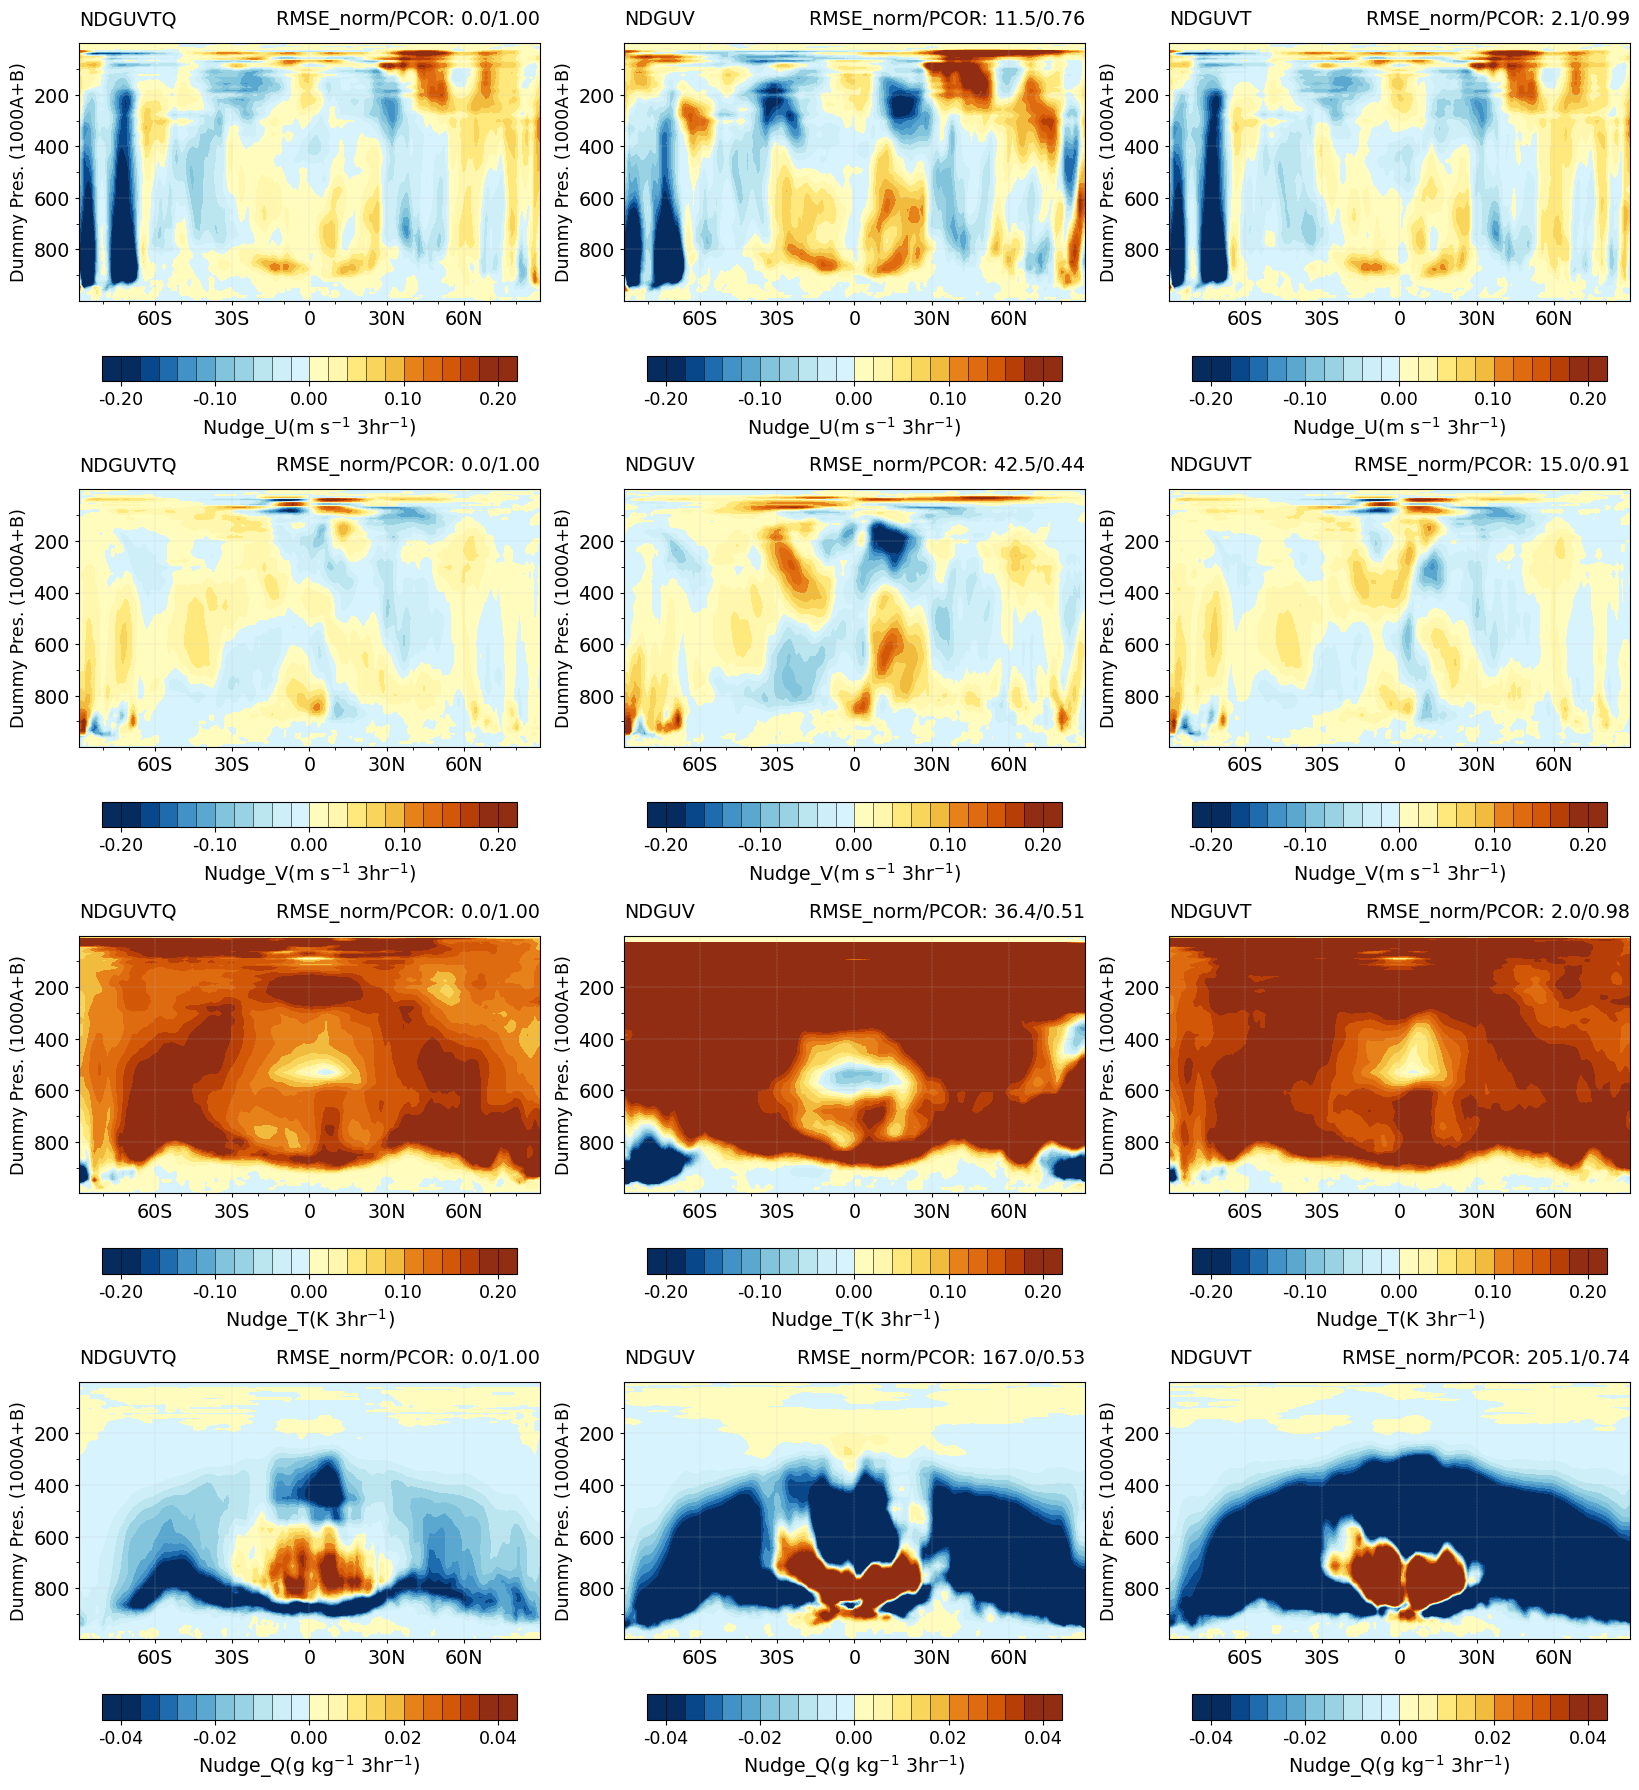

In [30]:
if __name__ == "__main__":
    top_path  = "/pscratch/sd/z/zhan391/SEACROGS_project"
    out_path  = os.path.join(top_path,"paper_material","fig_data","storm_track")
    fig_path  = os.path.join(top_path,"paper_material","case_study","storm_track","figures")

    # region of interest (north Atlantic)
    exp_name  =  'Sandy'
    exp_year  = 2012
    exp_mstr  = "NUDGING" # u,v,t,q, no spacial treatment 
    exp_mtag  = "NDG{}" # u,v,t,q, no spacial treatment 
    period    = "2012-10-22-2012-11-05"
    frequency = "3hourly"
    exps      = {
                 'SANDY2012_NDGUVTQ_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':         'NDGUVTQ',
                 'SANDY2012_NDGUV_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':           'NDGUV',
                 'SANDY2012_NDGUVT_F20TR_ne30pg2_EC30to60E2r2_pm-cpu':          'NDGUVT',
                }
    
    path_template  = "/pscratch/sd/z/zhan391/seacrogs_scratch/%(CASENAME)/EN00/post/atm/180x360_aave/clim"
    hist_tag = "eam.h2"
    south_north_cross(exp_name,exp_mstr,exp_year,period,frequency,exps,hist_tag,path_template)    